<a href="https://colab.research.google.com/github/spsgim/Streamit_Deployment/blob/main/EDA_Hypothesis_Modeling_Product_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Product sales forecasting**

**Problem Statement**

In the competitive retail industry, the ability to predict future sales accurately is crucial for operational and strategic planning. Product sales forecasting aims to estimate the number of products a store will sell in the future, based on various influencing factors such as store type, location, regional characteristics, promotional activities, and temporal variations (such as holidays and seasons). This project focuses on developing a predictive model that uses historical sales data from different stores to forecast sales for upcoming periods.

# **Importing Datasets and Libraries**

In [ ]:
!gdown 1ZPE21LrS_gvlxA4FNIn5Y9EhoFlyfc13

Downloading...
From: https://drive.google.com/uc?id=1ZPE21LrS_gvlxA4FNIn5Y9EhoFlyfc13
To: /content/TRAIN.csv
100% 9.33M/9.33M [00:00<00:00, 39.2MB/s]


In [ ]:
!gdown 1283_66iwnEkxDaPjXddwY-UqWyd6m8nh

Downloading...
From: https://drive.google.com/uc?id=1283_66iwnEkxDaPjXddwY-UqWyd6m8nh
To: /content/TEST_FINAL.csv
100% 849k/849k [00:00<00:00, 17.1MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy import stats
from scipy.stats import boxcox
from scipy.stats import shapiro, kstest, probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import f_oneway, kruskal
from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import StackingRegressor

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import pickle
import json
import os
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
!python --version

Python 3.10.12


In [ ]:
import scipy, sklearn
print(scipy.__version__)
print(sklearn.__version__)
print(lgb.__version__)
print(xgb.__version__)

1.13.1
1.3.2
4.4.0
2.1.0


In [ ]:
train = pd.read_csv('TRAIN.csv')
train

ID  Store_id Store_Type Location_Type Region_Code        Date  \
0       T1000001         1         S1            L3          R1  2018-01-01   
1       T1000002       253         S4            L2          R1  2018-01-01   
2       T1000003       252         S3            L2          R1  2018-01-01   
3       T1000004       251         S2            L3          R1  2018-01-01   
4       T1000005       250         S2            L3          R4  2018-01-01   
...          ...       ...        ...           ...         ...         ...   
188335  T1188336       149         S2            L3          R2  2019-05-31   
188336  T1188337       153         S4            L2          R1  2019-05-31   
188337  T1188338       154         S1            L3          R2  2019-05-31   
188338  T1188339       155         S3            L1          R2  2019-05-31   
188339  T1188340       152         S2            L1          R1  2019-05-31   

        Holiday Discount  #Order     Sales  
0             1      Yes       9   7011.84  
1             1      Yes      60  51789.12  
2             1      Yes      42  36868.20  
3             1      Yes      23  19715.16  
4             1      Yes      62  45614.52  
...         ...      ...     ...       ...  
188335        1      Yes      51  37272.00  
188336        1       No      90  54572.64  
188337        1       No      56  31624.56  
188338        1      Yes      70  49162.41  
188339        1       No      47  37977.00  

[188340 rows x 10 columns]

In [ ]:
test = pd.read_csv('TEST_FINAL.csv')
test

ID  Store_id Store_Type Location_Type Region_Code        Date  \
0      T1188341       171         S4            L2          R3  2019-06-01   
1      T1188342       172         S1            L1          R1  2019-06-01   
2      T1188343       173         S4            L2          R1  2019-06-01   
3      T1188344       174         S1            L1          R4  2019-06-01   
4      T1188345       170         S1            L1          R2  2019-06-01   
...         ...       ...        ...           ...         ...         ...   
22260  T1210601       186         S2            L5          R2  2019-07-31   
22261  T1210602        11         S4            L2          R1  2019-07-31   
22262  T1210603       185         S1            L1          R3  2019-07-31   
22263  T1210604        69         S1            L1          R4  2019-07-31   
22264  T1210605       365         S2            L1          R2  2019-07-31   

       Holiday Discount  
0            0       No  
1            0       No  
2            0       No  
3            0       No  
4            0       No  
...        ...      ...  
22260        0       No  
22261        0       No  
22262        0      Yes  
22263        0       No  
22264        0       No  

[22265 rows x 8 columns]

**Test data do not contains labels. We will need to take out validation set from train set for validation**

# **Exploratory Data Analysis**

### **Basic Exploration**

In [ ]:
df = train.copy()
test_df = test.copy()

In [ ]:
## Basic Info of the dataset. Datatypes and Presence of Missing Values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [ ]:
df.describe()

Store_id        Holiday         #Order          Sales
count  188340.000000  188340.000000  188340.000000  188340.000000
mean      183.000000       0.131783      68.205692   42784.327982
std       105.366308       0.338256      30.467415   18456.708302
min         1.000000       0.000000       0.000000       0.000000
25%        92.000000       0.000000      48.000000   30426.000000
50%       183.000000       0.000000      63.000000   39678.000000
75%       274.000000       0.000000      82.000000   51909.000000
max       365.000000       1.000000     371.000000  247215.000000

In [ ]:
df.describe(include='object')

ID Store_Type Location_Type Region_Code        Date Discount
count     188340     188340        188340      188340      188340   188340
unique    188340          4             5           4         516        2
top     T1000001         S1            L1          R1  2018-01-01       No
freq           1      88752         85140       63984         365   104051

**Insights**

---

<font color = 'blue'>

1. There are no missing values present
2. Datatypes fixes:
  - <font color = 'blue'>Date to Datetime
  - Store_id to Category
  - Holiday to Category
  - Discount to Category
  - Store_Type to Category
  - Location_Type to Category
  - Region_Code to Category
</font>

---

### **Fixing Datatype**

In [ ]:
def datatype_fix(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df['Store_id'] = df['Store_id'].astype('category')
  df['Holiday'] = df['Holiday'].astype('category')
  df['Discount'] = df['Discount'].astype('category')
  df['Store_Type'] = df['Store_Type'].astype('category')
  df['Location_Type'] = df['Location_Type'].astype('category')
  df['Region_Code'] = df['Region_Code'].astype('category')
  return df

In [ ]:
df = datatype_fix(df)
test_df = datatype_fix(test)

In [ ]:
df.dtypes

ID                       object
Store_id               category
Store_Type             category
Location_Type          category
Region_Code            category
Date             datetime64[ns]
Holiday                category
Discount               category
#Order                    int64
Sales                   float64
dtype: object

In [ ]:
df.describe()

Date         #Order          Sales
count                         188340  188340.000000  188340.000000
mean   2018-09-15 12:00:00.000000256      68.205692   42784.327982
min              2018-01-01 00:00:00       0.000000       0.000000
25%              2018-05-09 18:00:00      48.000000   30426.000000
50%              2018-09-15 12:00:00      63.000000   39678.000000
75%              2019-01-22 06:00:00      82.000000   51909.000000
max              2019-05-31 00:00:00     371.000000  247215.000000
std                              NaN      30.467415   18456.708302

In [ ]:
df.describe(include='category')

Store_id Store_Type Location_Type Region_Code  Holiday Discount
count     188340     188340        188340      188340   188340   188340
unique       365          4             5           4        2        2
top            1         S1            L1          R1        0       No
freq         516      88752         85140       63984   163520   104051

**Insights**

---

<font color = 'blue'>

1. There are total **365** Stores categoried in 4 different store types
2. There are 4 unique Regions a 5 location types
3. Mean and Median Sales as well as orders are far apart, which suggest skewness
4. By looking at the percentile values, there seems to be outliers present in the dataset

</font>

---

### **Value_counts and Unique Values**

In [ ]:
total_days = df['Date'].nunique()
print(f"Total Days: {total_days}")

Total Days: 516


In [ ]:
print(f"We have a {total_days} days Time series from {df['Date'].dt.date.min()} to {df['Date'].dt.date.max()} ")

We have a 516 days Time series from 2018-01-01 to 2019-05-31 


**We have a 17 months Time series from Jan'18 to May'19 to train the model**


In [ ]:
total_days_test = test_df['Date'].nunique()
print(f"We have a {total_days_test} days Time series from {test_df['Date'].dt.date.min()} to {test_df['Date'].dt.date.max()} ")

We have a 61 days Time series from 2019-06-01 to 2019-07-31 


**We have a 2 months Time series from Jun'19 to Jul'19 to test the final performance.**

In [ ]:
cat_cols = ['Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Holiday', 'Discount']

In [ ]:
def unique_values(df):
  for col in cat_cols:
    print(f'{col} : {df[col].unique().to_list()}')
    print("--"*20)
unique_values(df)

Store_id : [1, 253, 252, 251, 250, 249, 248, 247, 246, 254, 245, 11, 243, 242, 241, 240, 239, 238, 237, 244, 236, 255, 256, 273, 272, 271, 270, 269, 268, 9, 267, 10, 266, 264, 263, 262, 261, 260, 259, 258, 257, 265, 235, 234, 233, 211, 210, 209, 208, 207, 14, 206, 205, 212, 204, 202, 201, 200, 199, 198, 197, 196, 195, 203, 213, 214, 215, 232, 12, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 13, 218, 217, 216, 274, 15, 275, 277, 335, 334, 333, 332, 331, 330, 4, 329, 336, 328, 326, 325, 324, 323, 322, 321, 320, 319, 327, 318, 337, 339, 355, 354, 2, 353, 352, 351, 350, 349, 338, 348, 346, 345, 344, 343, 342, 3, 341, 340, 347, 317, 5, 316, 293, 7, 292, 291, 290, 289, 288, 287, 294, 286, 284, 283, 282, 281, 8, 280, 279, 278, 285, 295, 296, 297, 315, 314, 313, 312, 311, 310, 309, 308, 307, 306, 305, 6, 304, 303, 302, 301, 300, 299, 298, 276, 194, 193, 192, 87, 86, 85, 24, 84, 83, 82, 81, 88, 80, 78, 77, 76, 75, 74, 73, 72, 25, 79, 71, 89, 91, 108, 107, 106, 105, 104, 103,

In [ ]:
def val_cnt(df):
  for col in cat_cols:
    val_cnt_df = pd.DataFrame()
    val_cnt_df['Count'] = df[col].value_counts()
    val_cnt_df['Proportaion'] = df[col].value_counts(normalize=True).round(2)
    print(val_cnt_df)
    print("--"*20)

val_cnt(df)

          Count  Proportaion
Store_id                    
1           516          0.0
252         516          0.0
250         516          0.0
249         516          0.0
248         516          0.0
...         ...          ...
121         516          0.0
120         516          0.0
119         516          0.0
118         516          0.0
365         516          0.0

[365 rows x 2 columns]
----------------------------------------
            Count  Proportaion
Store_Type                    
S1          88752         0.47
S4          45924         0.24
S2          28896         0.15
S3          24768         0.13
----------------------------------------
               Count  Proportaion
Location_Type                    
L1             85140         0.45
L2             48504         0.26
L3             29928         0.16
L5             13932         0.07
L4             10836         0.06
----------------------------------------
             Count  Proportaion
Region_Code         

In [ ]:
## #Holidays
df.groupby('Holiday')['Date'].nunique()

Holiday
0    448
1     68
Name: Date, dtype: int64

**Insights**

---

<font color = 'blue'>

1. The dataset contains four categories of Stores, five location types, and four regions
2. 45% of sales instances are of items with discount  
3. 68 out of 516 (13%) days are Holiday. Thus we have sufficient datapoints to test the hypothesis.
4. Locations L1, L2, and L3 are having **87%** of transactions.

</font>

---

### **Univariate Analysis**


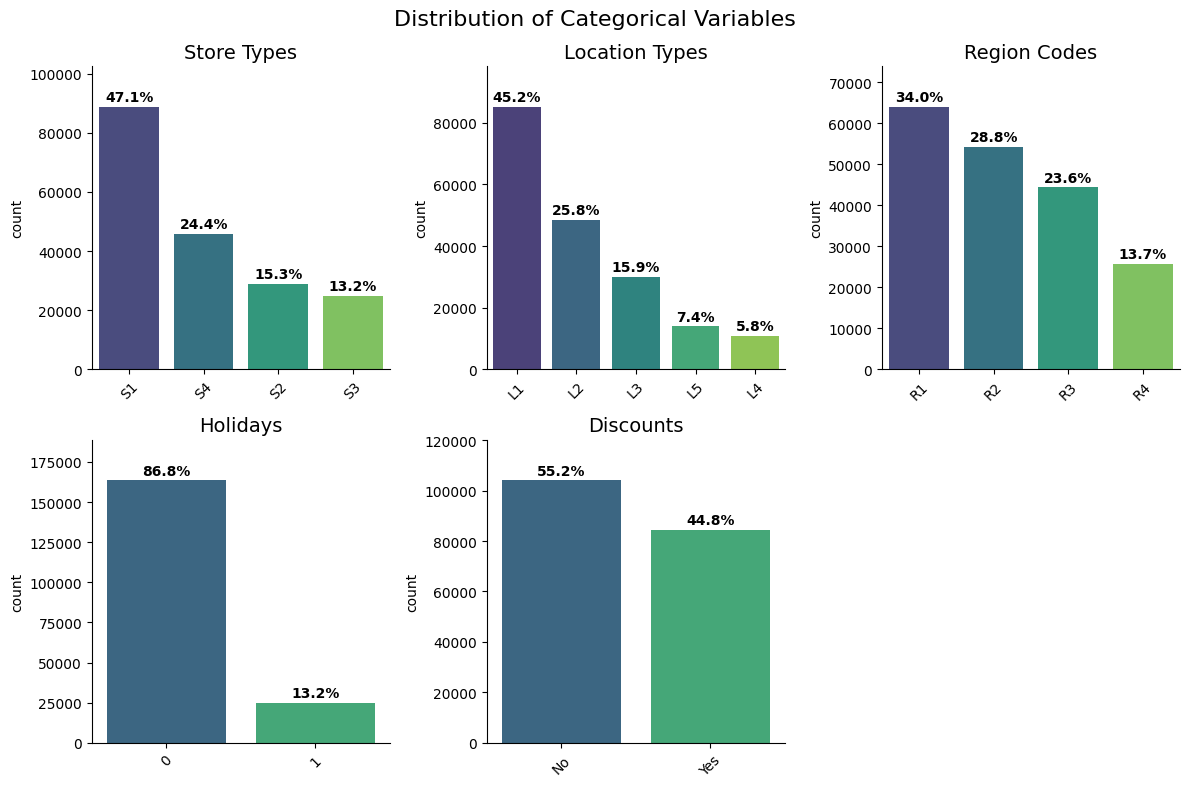

In [ ]:
def plot_categorical(df, column, ax, title):
    # Calculate percentages
    counts = df[column].value_counts()
    total = len(df[column])
    percentages = counts / total * 100

    # Plot
    sns.countplot(x=column, data=df, ax=ax, palette='viridis', order=df[column].value_counts().index)

    # Add percentage labels
    for i, v in enumerate(counts):
        ax.text(i, v + 0.01*ax.get_ylim()[1], f'{percentages[i]:.1f}%',
                ha='center', va='bottom',
                fontweight='bold', fontsize=10)

    # Customize
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)

    # Remove top and right spines
    sns.despine(ax=ax)

    # Adjust y-axis to make room for labels
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1] * 1.1)  # Increase y-axis limit by 10%

# Set up the plot
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Distribution of Categorical Variables', fontsize=16)

# Plot each categorical variable
plot_categorical(df, 'Store_Type', axs[0, 0], 'Store Types')
plot_categorical(df, 'Location_Type', axs[0, 1], 'Location Types')
plot_categorical(df, 'Region_Code', axs[0, 2], 'Region Codes')
plot_categorical(df, 'Holiday', axs[1, 0], 'Holidays')
plot_categorical(df, 'Discount', axs[1, 1], 'Discounts')

# Remove the unused subplot
fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()

**Insights**

___

<font color = 'blue'>

1. Store_Type: S1 stores are the most common (47%), followed by S4 (24%). This suggests a significant variation in store representation.
2. Location_Type: L1 locations dominate (45%), with L2 following (26%). L4 and L5 are relatively rare.
3. Region_Code: R1 and R2 account for 63% of the data, indicating a possible geographical concentration.
4. Holiday: Only 13% of the days are holidays, which is expected but important to note for later analysis.
5. Discount: The split is relatively even (55% No, 45% Yes), suggesting frequent use of discounts.

---

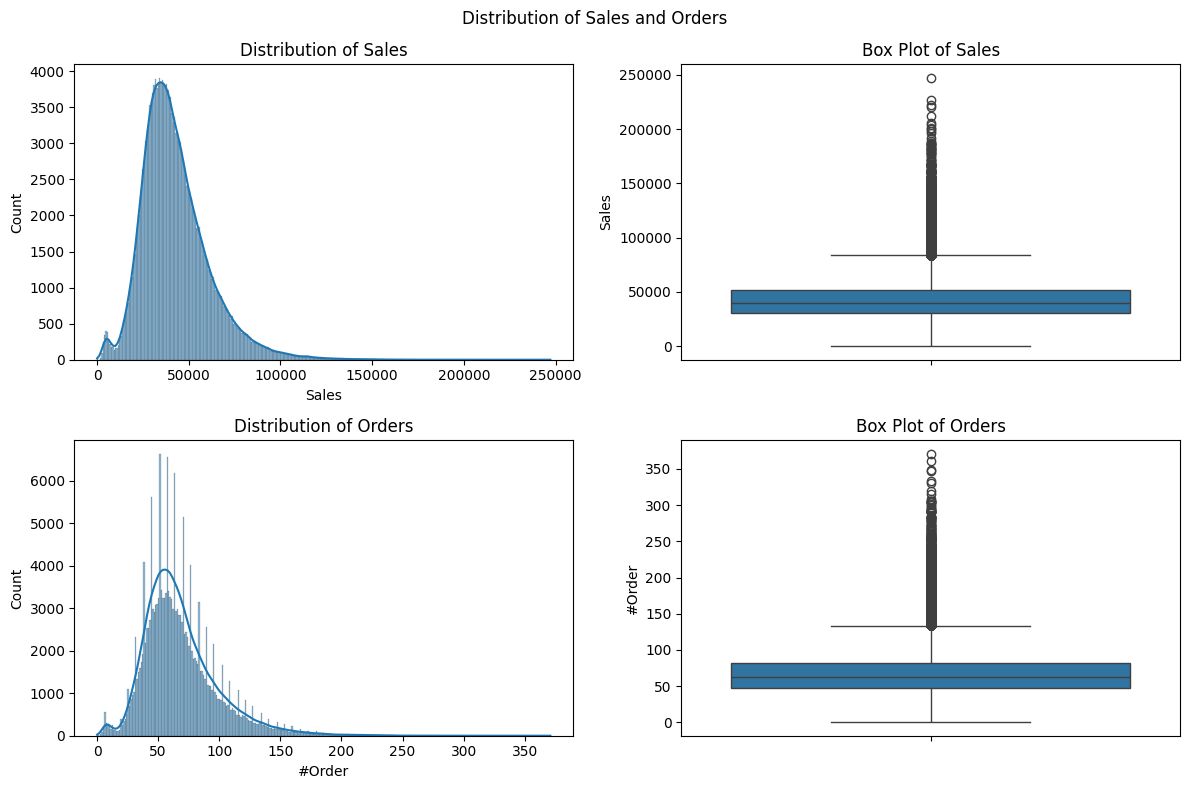

In [ ]:
plt.figure(figsize=(12, 8))

# Sales Distribution
plt.subplot(2, 2, 1)
sns.histplot(df['Sales'], kde=True)
plt.title('Distribution of Sales')

plt.subplot(2, 2, 2)

sns.boxplot(y='Sales', data=df, orient = 'h')
plt.title('Box Plot of Sales')

# Order Distribution
plt.subplot(2, 2, 3)
sns.histplot(df['#Order'], kde=True)
plt.title('Distribution of Orders')

plt.subplot(2, 2, 4)
sns.boxplot(y='#Order', data=df, orient = 'h')
plt.title('Box Plot of Orders')

plt.suptitle('Distribution of Sales and Orders')
plt.tight_layout()
plt.show()

**Insights**

___

<font color = 'blue'> The right-tailed distribution for both sales and orders suggests that while most sales/orders fall within a certain range, there are occasional high-value outliers. This is common in retail data.

---


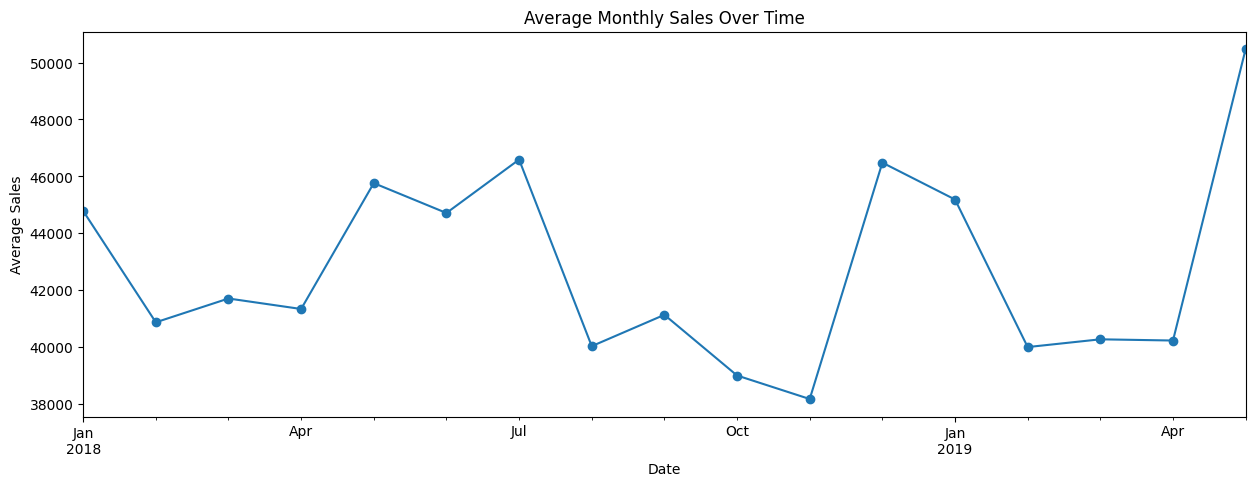

In [ ]:
# Resample data to monthly frequency and calculate mean sales
monthly_sales = df.set_index('Date')['Sales'].resample('M').mean()

plt.figure(figsize=(15, 5))
monthly_sales.plot(marker = "o")
plt.title('Average Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.show()

**Insights**

___

<font color = 'blue'>
We do not have enough data to conclude but there seems to have a seasonality in the time-series. Similar pattern obeseved in the Months between Jan-May

___

### **Bivariate Analysis**

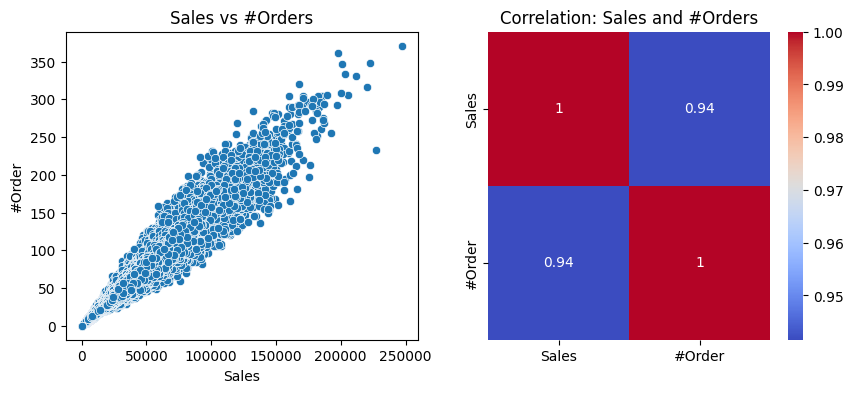

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.scatterplot(x ='Sales',y = "#Order", data=df)
plt.title('Sales vs #Orders')

plt.subplot(1, 2, 2)
# Correlation analysis:
correlation = df[['Sales', '#Order']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation: Sales and #Orders');

**Insights**

___

**Correlation between Sales and Orders (94%):**

  <font color = 'blue'>This strong positive correlation indicates that as the number of orders increases, sales tend to increase proportionally. This is expected but confirms that higher order volume strongly relates to higher sales.

  We might want to investigate if this relationship holds true across all store types and locations.
</font>

---

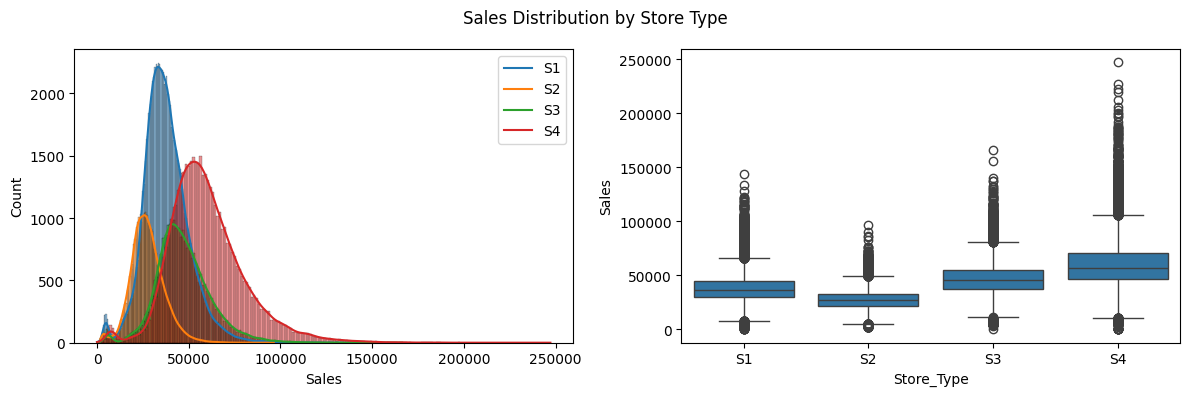

In [ ]:
sns.choose_light_palette('colorblind')
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
sns.histplot(df[df['Store_Type']=='S1']['Sales'], kde=True)
sns.histplot(df[df['Store_Type']=='S2']['Sales'],kde=True)
sns.histplot(df[df['Store_Type']=='S3']['Sales'],kde=True)
sns.histplot(df[df['Store_Type']=='S4']['Sales'],kde=True)
plt.legend(['S1', 'S2', 'S3', 'S4'])

plt.subplot(1, 2, 2)
sns.boxplot(x='Store_Type', y='Sales', data=df)

plt.suptitle('Sales Distribution by Store Type')
plt.tight_layout()
plt.show()

**Insights**

___

**Sales by Store Type:**



- <font color = 'blue'>S4 having the highest median sales suggests these stores are the most profitable on average.
- S2 having the lowest median sales might indicate smaller stores or less favorable locations.
- The fact that S3 > S1 in median sales is interesting and might warrant further investigation.
- Outliers in all store types suggest occasional high-value sales across all store formats.

---

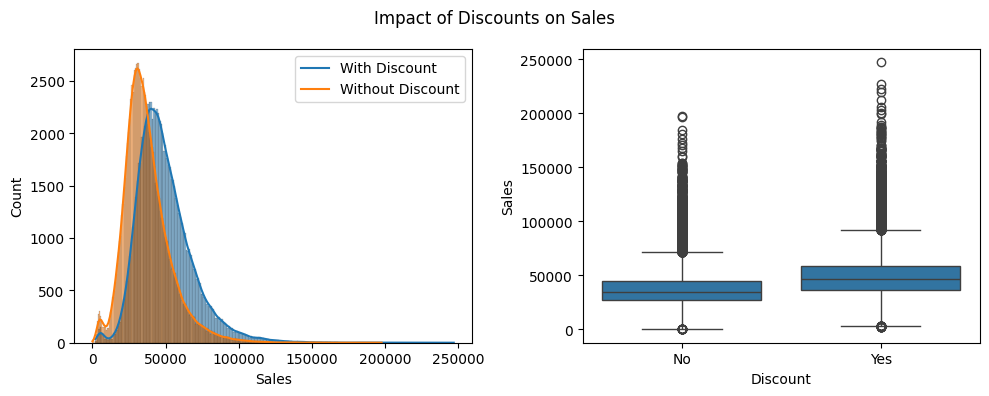

In [ ]:
# Impact of Discounts on Sales
sns.choose_light_palette('colorblind')
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
sns.histplot(df[df['Discount']=='Yes']['Sales'], kde=True)
sns.histplot(df[df['Discount']!='Yes']['Sales'], kde=True)
plt.legend(['With Discount', 'Without Discount'])

plt.subplot(1, 2, 2)
sns.boxplot(x='Discount', y='Sales', data=df)

plt.suptitle('Impact of Discounts on Sales')
plt.tight_layout()
plt.show()

**Insights**

___

**Impact of Discounts on Sales:**


<font color = 'blue'>Higher median sales with discounts suggest that discount strategies are effective in driving sales volume.

---

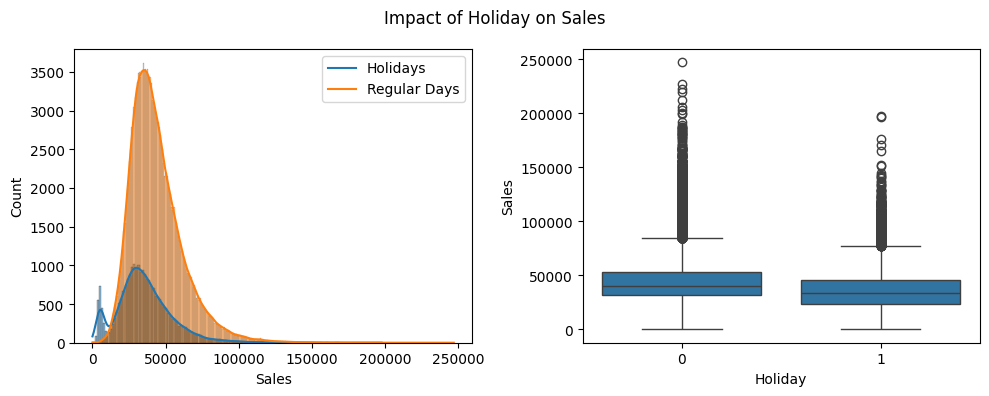

In [ ]:
# Impact of Discounts on Sales
sns.choose_light_palette('colorblind')
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
sns.histplot(df[df['Holiday']==1]['Sales'], kde=True)
sns.histplot(df[df['Holiday']!=1]['Sales'], kde=True)
plt.legend(['Holidays', 'Regular Days'])

plt.subplot(1, 2, 2)
sns.boxplot(x='Holiday', y ='Sales', data=df)

plt.suptitle('Impact of Holiday on Sales')
plt.tight_layout()
plt.show()

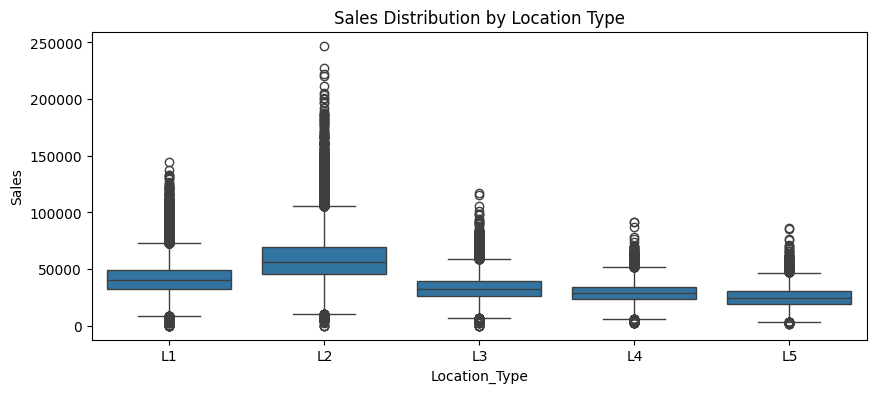

In [ ]:
# Sales by location type
plt.figure(figsize=(10,4))
sns.boxplot(x='Location_Type', y='Sales', data=df)
plt.title('Sales Distribution by Location Type')
plt.show()

**Insights**

___


**Sales by location type:**

   <font color=blue>The order of sales by location (L2 > L1 > L3 > L4 > L5) provides insights into the importance of location.

**Implications:**
   - <font color=blue>L2 locations seem to be prime spots for sales. We should investigate what characterizes these locations.
   - L4 and L5 locations might need additional support or different strategies to improve sales.
   - This information could be valuable for future store placement decisions.

---

In [ ]:
## Mean Sales by Store
avg_sales_by_Store_id = df.groupby('Store_id')['Sales'].mean().sort_values(ascending=False).round(2)
avg_sales_by_Store_id.head()

Store_id
175    101860.96
337     95624.84
126     89829.13
312     86996.74
146     84685.45
Name: Sales, dtype: float64

In [ ]:
avg_sales_by_Store_id.describe()

count       365.000000
mean      42784.328027
std       13051.704429
min       18693.460000
25%       33852.620000
50%       40640.010000
75%       50561.130000
max      101860.960000
Name: Sales, dtype: float64

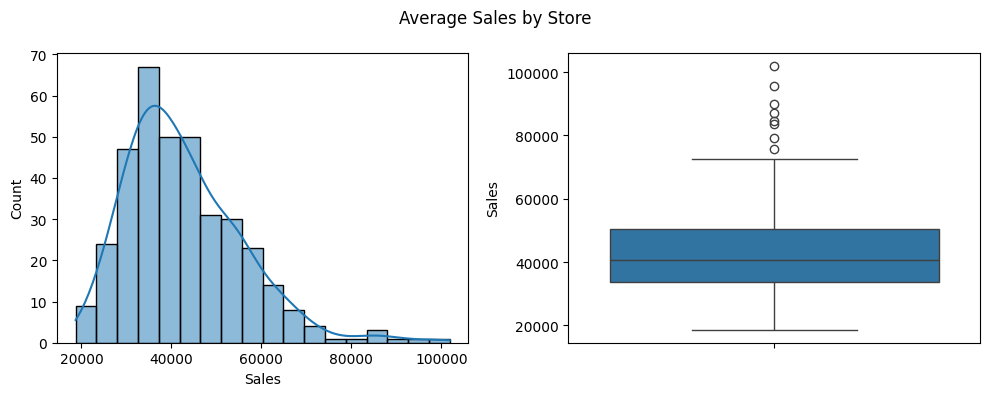

In [ ]:
## Mean Sales by Store
sns.choose_light_palette('colorblind')
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
sns.histplot(avg_sales_by_Store_id, kde=True)

plt.subplot(1, 2, 2)
sns.boxplot(avg_sales_by_Store_id)

plt.suptitle('Average Sales by Store')
plt.tight_layout()
plt.show()

**Insights**

___


**Mean Sales by Store_id:**

   <font color=blue>The distribution of average sales of each store is skewed towards right.

**Implications:**
   - <font color=blue> Some stores have significantly higher sales than usual.

---

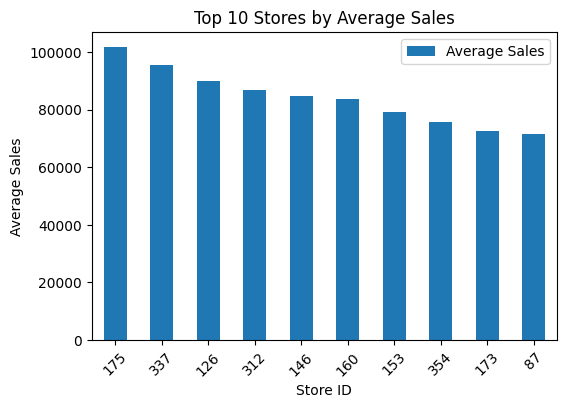

In [ ]:
## Top 10 stores
top_10_stores = avg_sales_by_Store_id[:10].reset_index()
top_10_stores.columns = ['Store_id', 'Average Sales']
top_10_stores['Store_id'] = top_10_stores['Store_id'].astype('category')

top_10_stores.plot(kind='bar', x='Store_id', y='Average Sales', figsize=(6, 4))

plt.title('Top 10 Stores by Average Sales')
plt.xlabel('Store ID')
plt.ylabel('Average Sales')
plt.xticks(rotation=45);
plt.show()

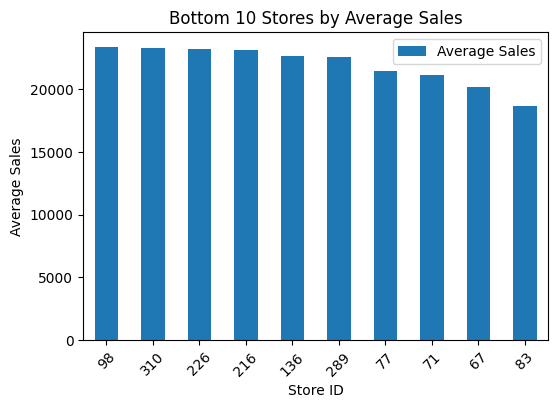

In [ ]:
# Create the plot for bottom 10 stores
bottom_10_stores = avg_sales_by_Store_id[-10:].reset_index()
bottom_10_stores.columns = ['Store_id', 'Average Sales']
bottom_10_stores['Store_id'] = bottom_10_stores['Store_id'].astype('category')

bottom_10_stores.plot(kind='bar', x='Store_id', y='Average Sales', figsize=(6, 4));
plt.title('Bottom 10 Stores by Average Sales');
plt.xlabel('Store ID');
plt.ylabel('Average Sales');
plt.xticks(rotation=45);

plt.show()

In [ ]:
import plotly.express as px
fig = px.box(df, x="Store_id", y="Sales")
fig.show()

### **Feature Engineering**

In [ ]:
train_dtypes_fixed = df.copy()
train_dtypes_fixed.head(2)

ID Store_id Store_Type Location_Type Region_Code       Date Holiday  \
0  T1000001        1         S1            L3          R1 2018-01-01       1   
1  T1000002      253         S4            L2          R1 2018-01-01       1   

  Discount  #Order     Sales  
0      Yes       9   7011.84  
1      Yes      60  51789.12

In [ ]:
## Extracting Year, Month, Quarter, Week, Day, Day of Week from Date

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Day'] = df['Date'].dt.day
df['Week'] = df['Date'].dt.isocalendar().week
df['Day of Week'] = df['Date'].dt.day_name()

columns = ['Year', 'Month', 'Quarter', 'Day', 'Week', 'Day of Week']
for col in columns:
  df[col] = df[col].astype('category')

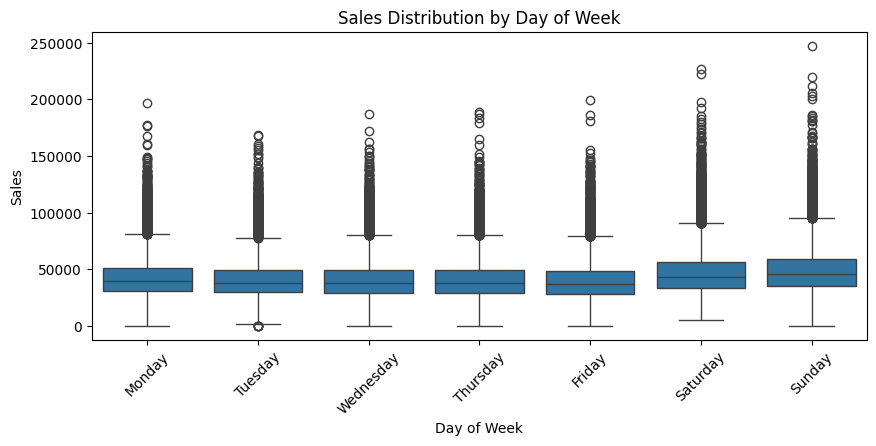

In [ ]:
# Daily Sales Pattern
## Sales Distribution by Day of Week
plt.figure(figsize=(10,4))
sns.boxplot(x='Day of Week', y='Sales', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Sales Distribution by Day of Week')
plt.xticks(rotation=45)
plt.show()

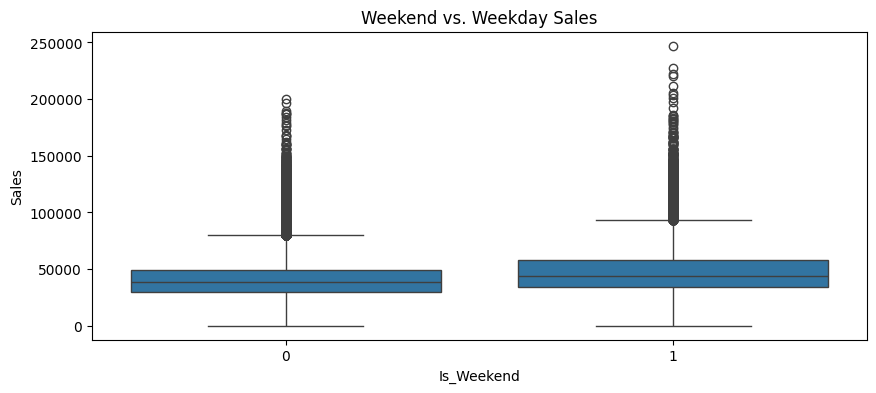

In [ ]:
# Observation suggest higher weekend sales compared to relatively similar weekday sales suggest a clear weekly pattern.

## Getting Weekend Sales
# Weekend vs. Weekday sales
df['Is_Weekend'] = df['Date'].dt.dayofweek.isin([5,6]).map({True: 1, False: 0})
df['Is_Weekend'] = df['Is_Weekend'].astype('category')
plt.figure(figsize=(10,4))
sns.boxplot(x='Is_Weekend', y='Sales', data=df)
plt.title('Weekend vs. Weekday Sales')
plt.show()

**Insights**

___

**Daily Sales Pattern:**


<font color = 'blue'>
The higher weekend sales compared to relatively similar weekday sales suggest a clear weekly pattern.

---

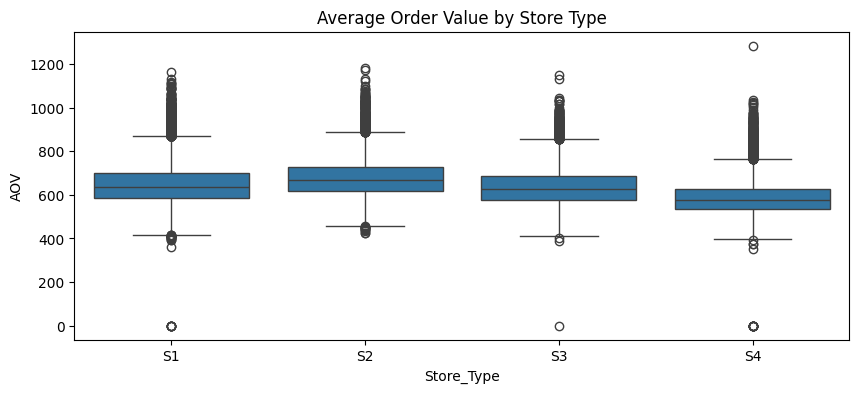

In [ ]:
## Extracting Feature : Average Order Value (AOV)
## AOV = Sales/#Orders
df['AOV'] = df['Sales'] / df['#Order']
df['AOV'].fillna(0, inplace=True)
df['AOV'] = df['AOV'].round(2)


# Average order value (AOV) by store type:
plt.figure(figsize=(10,4))
sns.boxplot(x='Store_Type', y='AOV', data=df)
plt.title('Average Order Value by Store Type')
plt.show()

**Insights**

___


<font color=blue>Average Order Value (AOV) by store type:
   The order of AOV (S2 > S1 > S3 > S4) is quite interesting, especially given that S4 had the highest median sales overall.

   **Implications:**
   - <font color=blue>S2 stores might be selling higher-value items or targeting a more affluent customer base.
   - S4 stores, despite having lower AOV, might be compensating with higher volume of sales.
   - This could suggest different marketing and inventory strategies for different store types.

---

### **Multivariate Analysis**

In [ ]:
train_feature_extracted = df.copy()
train_feature_extracted.head(2)

ID Store_id Store_Type Location_Type Region_Code       Date Holiday  \
0  T1000001        1         S1            L3          R1 2018-01-01       1   
1  T1000002      253         S4            L2          R1 2018-01-01       1   

  Discount  #Order     Sales  Year Month Quarter Day Week Day of Week  \
0      Yes       9   7011.84  2018     1       1   1    1      Monday   
1      Yes      60  51789.12  2018     1       1   1    1      Monday   

  Is_Weekend     AOV  
0          0  779.09  
1          0  863.15

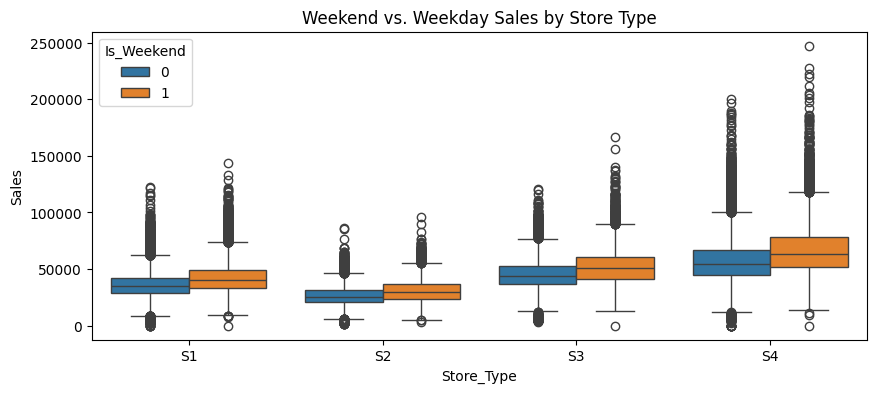

In [ ]:
# Weekend vs. Weekday sales by store type
plt.figure(figsize=(10,4))
sns.boxplot(x='Store_Type', y='Sales', hue='Is_Weekend', data=df)
plt.title('Weekend vs. Weekday Sales by Store Type')
plt.show()

**Insights**

___

**Weekend vs. Weekday sales by store type:**

   <font color=blue>The consistently higher weekend sales across all store types confirm our earlier observation about the weekly pattern.

**Implications:**
   - <font color=blue>This consistent pattern might suggest the need for adjusted staffing and inventory management for weekends across all store types.
   - We might want to explore if certain promotions or marketing strategies could be more effective on weekends.


---

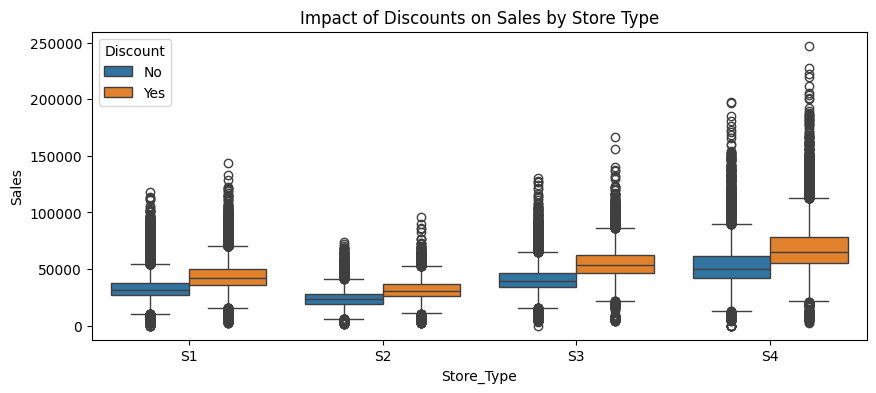

In [ ]:
# Discount effectiveness by store type:
plt.figure(figsize=(10,4))
sns.boxplot(x='Store_Type', y='Sales', hue='Discount', data=df)
plt.title('Impact of Discounts on Sales by Store Type')
plt.show()

**Insights**

___


**Discount effectiveness by store type:**


   <font color=blue>The fact that all store types show higher median sales when discounts are offered suggests that discounting is an effective strategy across the board. However, the degree of effectiveness might vary.

  **Implications:**
   - <font color=blue>Discounts are universally effective, but we should investigate the profit margins to ensure they're truly beneficial.
   - We might want to explore if certain store types benefit more from discounts than others.

---

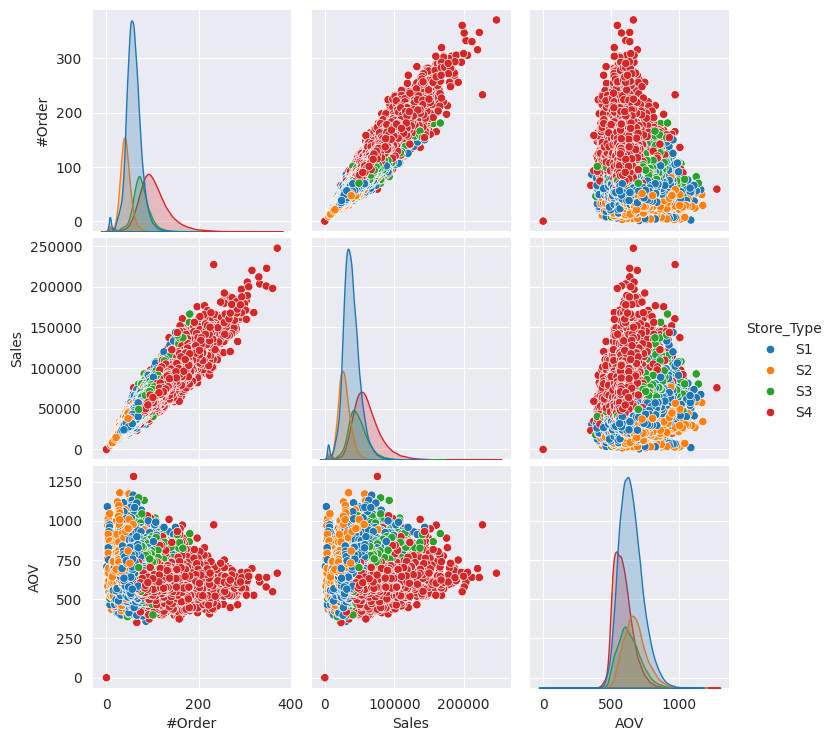

In [ ]:
sns.pairplot(df, hue='Store_Type');

**Insights**

___

**Pairplot:**

   - <font color=blue> #Orders and Sales is correlated.
   - S1 store_type dominates others with higher #Orders, Sales.

---

**#Order and Sales Distribution categories**

In [ ]:
cat_features = train_dtypes_fixed.dtypes[df.dtypes == 'category'].index.to_list()
cat_features.remove('Store_id')
print(cat_features)

['Store_Type', 'Location_Type', 'Region_Code', 'Holiday', 'Discount']


In [ ]:
def plot_ineractions(df, var1, var2, value, agg):
  sales_pivot = pd.pivot_table(df, values=value, index=var1, columns=var2, aggfunc=agg).fillna(0)
  return sales_pivot.style.background_gradient(cmap='coolwarm').format("{:.0f}")

print('All Categories Interacations\n')

for i in range(0, len(cat_features)-1):
  for j in range(i+1, len(cat_features)):
    print('--'*20)
    print("Median Sales by", cat_features[i], "and" , cat_features[j])
    styled_table_sales = plot_ineractions(df, cat_features[i],cat_features[j], 'Sales', 'median')
    display(styled_table_sales)

    print()
    # print("Median #Order by", cat_features[i], "and" , cat_features[j])
    # styled_table_order = plot_ineractions(df,  cat_features[i],cat_features[j], '#Order', 'median')
    # display(styled_table_order)

All Categories Interacations

----------------------------------------
Median Sales by Store_Type and Location_Type



----------------------------------------
Median Sales by Store_Type and Region_Code



----------------------------------------
Median Sales by Store_Type and Holiday



----------------------------------------
Median Sales by Store_Type and Discount



----------------------------------------
Median Sales by Location_Type and Region_Code



----------------------------------------
Median Sales by Location_Type and Holiday



----------------------------------------
Median Sales by Location_Type and Discount



----------------------------------------
Median Sales by Region_Code and Holiday



----------------------------------------
Median Sales by Region_Code and Discount



----------------------------------------
Median Sales by Holiday and Discount


**Insights**


___


1. **Store_Type S4 Performance**:
   - S4 has the highest median sales and order numbers across most categories, particularly in high-performing locations (L2) and regions (R4).
   - Median sales and orders are significantly higher during holidays and weekends, indicating a strong consumer preference during these times.

2. **Impact of Location_Type**:
   - L2 stands out with consistently high median sales and orders across all categories, making it the most lucrative location type.
   - L1 and L3 also perform well but not as strongly as L2, while L4 and L5 generally have lower median sales and orders.

3. **Effect of Discounts**:
   - Discounts lead to higher median sales and order numbers across all store and location types.
   - The increase is particularly notable during weekends and holidays, suggesting that promotional strategies are highly effective.

4. **Weekend vs. Weekday Sales**:
   - Median sales and orders are higher on weekends across all store types, locations, and regions.
   - This trend indicates increased consumer activity during weekends, suggesting opportunities for targeted marketing and promotions.

5. **Regional Variations**:
   - R1 has the highest median sales and order numbers, especially when discounts are applied.
   - All regions show improved performance with discounts, but R1 and R3 benefit the most.

6. **Holiday Influence**:
   - Sales and orders decrease during holidays across all store types, locations, and regions, except for S4, which still performs well.
   - This pattern suggests that while holidays typically reduce median sales and orders, certain store types can still capitalize on holiday traffic.

7. **Combination of Discounts and Weekends**:
   - The combination of discounts and weekends results in the highest median sales and orders.
   - This suggests that combining these strategies can maximize revenue and customer engagement.

8. **Store_Type Specific Trends**:
   - S3 performs well in regions R3 and R4, and also benefits significantly from discounts.
   - S2 shows lower performance across most metrics, especially in L2 where it has no sales data.

9. **Sales by Holiday and Discount**:
   - Sales are higher with discounts on both holidays and non-holidays, but the increase is more pronounced on non-holidays.
   - This indicates that while discounts are effective overall, they are particularly impactful on regular days.

10. **Sales and Orders by Is_Weekend and Discount**:
   - Both sales and orders see substantial increases with discounts on weekends compared to weekdays.
   - This highlights the effectiveness of weekend promotions in boosting sales and customer activity.

# **Outliers Teatment**

In [ ]:
## Sales Stastical Summary
df['Sales'].describe()

count    188340.000000
mean      42784.327982
std       18456.708302
min           0.000000
25%       30426.000000
50%       39678.000000
75%       51909.000000
max      247215.000000
Name: Sales, dtype: float64

In [ ]:
# Understanding distribution
for i in range(0, 110, 10):
  print("{} percentile value is {}".format(i, np.percentile(df['Sales'], i)))

0 percentile value is 0.0
10 percentile value is 23439.756
20 percentile value is 28455.0
30 percentile value is 32268.0
40 percentile value is 35940.0
50 percentile value is 39678.0
60 percentile value is 43883.856
70 percentile value is 48846.0
80 percentile value is 55515.0
90 percentile value is 66282.0
100 percentile value is 247215.0


In [ ]:
# Further evaluation of the distribution
for i in range(90, 101, 1):
  print("{} percentile value is {}".format(i, np.percentile(df['Sales'], i)))

90 percentile value is 66282.0
91 percentile value is 67838.44920000002
92 percentile value is 69638.64000000001
93 percentile value is 71688.81000000006
94 percentile value is 73965.0
95 percentile value is 76809.29999999993
96 percentile value is 80317.32
97 percentile value is 84738.0
98 percentile value is 91029.0
99 percentile value is 102159.0
100 percentile value is 247215.0


In [ ]:
df[df['Sales'] > df['Sales'].quantile(.99)].sort_values("Sales", ascending=False)

ID Store_id Store_Type Location_Type Region_Code       Date  \
178648  T1178649      175         S4            L2          R1 2019-05-05   
178372  T1178373       87         S4            L2          R3 2019-05-04   
178304  T1178305      175         S4            L2          R1 2019-05-04   
63672   T1063673      337         S4            L2          R1 2018-06-24   
168624  T1168625      315         S4            L2          R1 2019-04-07   
...          ...      ...        ...           ...         ...        ...   
4829    T1004830      173         S4            L2          R1 2018-01-14   
178784  T1178785       30         S1            L2          R2 2019-05-05   
42874   T1042875      357         S4            L1          R1 2018-04-28   
90379   T1090380      160         S4            L2          R1 2018-09-05   
115043  T1115044      126         S4            L2          R2 2018-11-12   

       Holiday Discount  #Order     Sales  Year Month Quarter Day Week  \
178648       0      Yes     371  247215.0  2019     5       2   5   18   
178372       0      Yes     233  227127.0  2019     5       2   4   18   
178304       0      Yes     348  222516.0  2019     5       2   4   18   
63672        0      Yes     316  219984.0  2018     6       2  24   25   
168624       0      Yes     331  211914.0  2019     4       2   7   14   
...        ...      ...     ...       ...   ...   ...     ...  ..  ...   
4829         1      Yes     135  102196.8  2018     1       1  14    2   
178784       0      Yes     124  102192.0  2019     5       2   5   18   
42874        0       No     191  102183.0  2018     4       2  28   17   
90379        0      Yes     186  102165.0  2018     9       3   5   36   
115043       0      Yes     159  102162.0  2018    11       4  12   46   

       Day of Week Is_Weekend     AOV  
178648      Sunday          1  666.35  
178372    Saturday          1  974.79  
178304    Saturday          1  639.41  
63672       Sunday          1  696.15  
168624      Sunday          1  640.22  
...            ...        ...     ...  
4829        Sunday          1  757.01  
178784      Sunday          1  824.13  
42874     Saturday          1  534.99  
90379    Wednesday          0  549.27  
115043      Monday          0  642.53  

[1883 rows x 18 columns]

**Insights**

---

- We have significant instances of above 99%ile sales.
- This looks fine as this is a common behaviour in Retail industry

In [ ]:
# Check if high sales align with holidays or discounts or weekend

high_sales = df[df['Sales'] >  df['Sales'].quantile(.99)]
high_sales_holidays = high_sales[high_sales['Holiday'] == 1]
high_sales_discounts = high_sales[high_sales['Discount'] == 'Yes']
high_sales_weekends = high_sales[high_sales['Is_Weekend'] == 'Weekend']

print(f"High sales on holidays: {len(high_sales_holidays)/len(high_sales) *100:.2f}%")
print(f"High sales with discounts: {len(high_sales_discounts) / len(high_sales) *100:.2f}%")
print(f"High sales on Weekends: {len(high_sales_weekends) / len(high_sales) *100:.2f}")

High sales on holidays: 7.33%
High sales with discounts: 76.16%
High sales on Weekends: 0.00


In [ ]:
high_sales['Store_Type'].value_counts()

Store_Type
S4    1748
S3      89
S1      46
S2       0
Name: count, dtype: int64

In [ ]:
high_sales['Location_Type'].value_counts()

Location_Type
L2    1764
L1     116
L3       3
L4       0
L5       0
Name: count, dtype: int64

In [ ]:
high_sales['Region_Code'].value_counts()

Region_Code
R1    1242
R2     286
R3     248
R4     107
Name: count, dtype: int64

**Insights**

<font color=blue>
Given the significant association with discounts and specific store and location types, these high sales values likely represent legitimate high sales events rather than data errors.

**Capping Outliers:**

To prevent the outliers from skewing the model but still retaining the valuable information, we can cap the sales values at the 99th percentile.

Capped Value: 102159.0


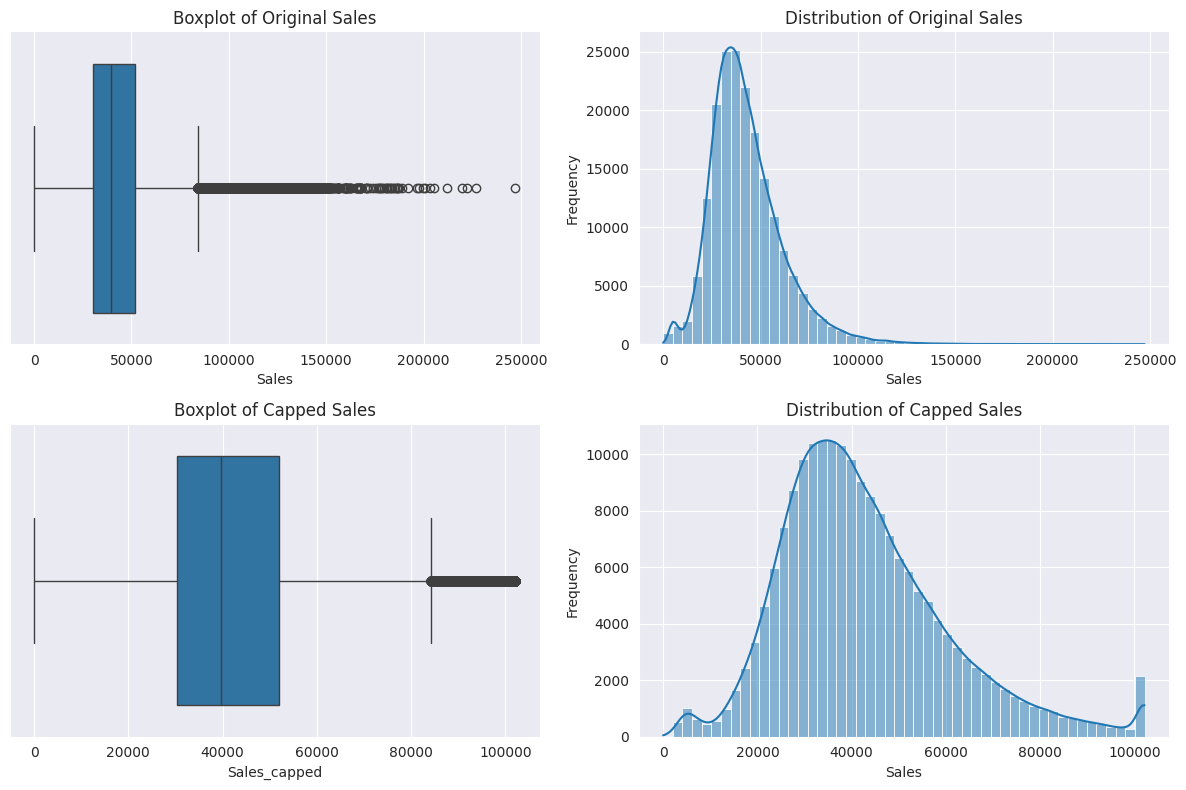

In [ ]:
# Capping the sales values at the 99th percentile
cap_value = df['Sales'].quantile(0.99)
df['Sales_capped'] = df['Sales'].apply(lambda x: min(x, cap_value))
print(f"Capped Value: {cap_value}")


sns.set_style('darkgrid')
plt.figure(figsize=(12, 8))
# Boxplot to check the effect of capping
plt.subplot(2, 2, 1)
sns.boxplot(x=df['Sales'])
plt.title('Boxplot of Original Sales')

# Histogram of capped sales
plt.subplot(2, 2, 2)
sns.histplot(df['Sales'], bins=50, kde=True)
plt.title('Distribution of Original Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')


plt.subplot(2, 2, 3)
sns.boxplot(x=df['Sales_capped'])
plt.title('Boxplot of Capped Sales')

plt.subplot(2, 2, 4)
sns.histplot(df['Sales_capped'], bins=50, kde=True)
plt.title('Distribution of Capped Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')

sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
print(df['Sales_capped'].describe())

count    188340.000000
mean      42619.331593
std       17758.031781
min           0.000000
25%       30426.000000
50%       39678.000000
75%       51909.000000
max      102159.000000
Name: Sales_capped, dtype: float64


# **Time Series Analysis**

In [ ]:
train_capped_outliers = df.copy()
train_capped_outliers.head(2)

ID Store_id Store_Type Location_Type Region_Code       Date Holiday  \
0  T1000001        1         S1            L3          R1 2018-01-01       1   
1  T1000002      253         S4            L2          R1 2018-01-01       1   

  Discount  #Order     Sales  Year Month Quarter Day Week Day of Week  \
0      Yes       9   7011.84  2018     1       1   1    1      Monday   
1      Yes      60  51789.12  2018     1       1   1    1      Monday   

  Is_Weekend     AOV  Sales_capped  
0          0  779.09       7011.84  
1          0  863.15      51789.12

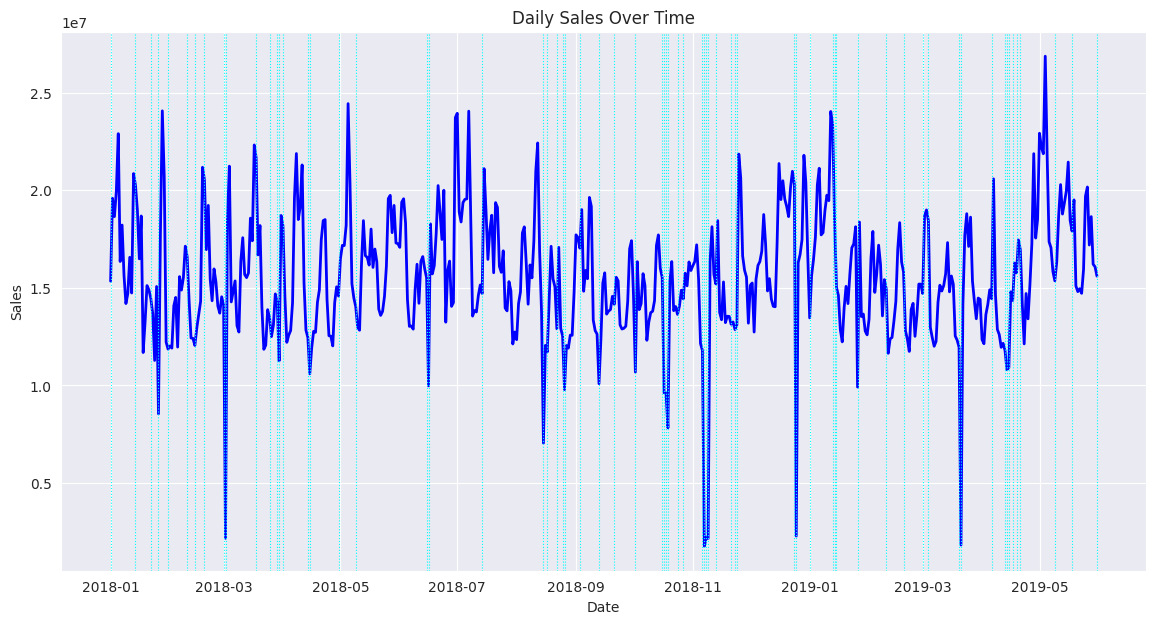

In [ ]:
sns.set_style('darkgrid')
# Aggregate daily sales
daily_sales = df.groupby('Date')['Sales'].sum().reset_index()

# Plotting the time series
plt.figure(figsize=(14, 7))
plt.plot(daily_sales['Date'], daily_sales['Sales'], color='blue', linewidth=2)

# Add vertical lines for holidays
holiday_dates = df[df['Holiday'] == 1]['Date'].unique()

for date in holiday_dates:
    plt.axvline(x=date, color='cyan', linestyle=':', linewidth=0.8)

plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [ ]:
# Ensure Date is set as the index
daily_sales = df[['Date', 'Sales']].set_index('Date')

# Confirm the index type
print(daily_sales.index.dtype)

datetime64[ns]


In [ ]:
daily_sales.describe()

Sales
count  188340.000000
mean    42784.327982
std     18456.708302
min         0.000000
25%     30426.000000
50%     39678.000000
75%     51909.000000
max    247215.000000

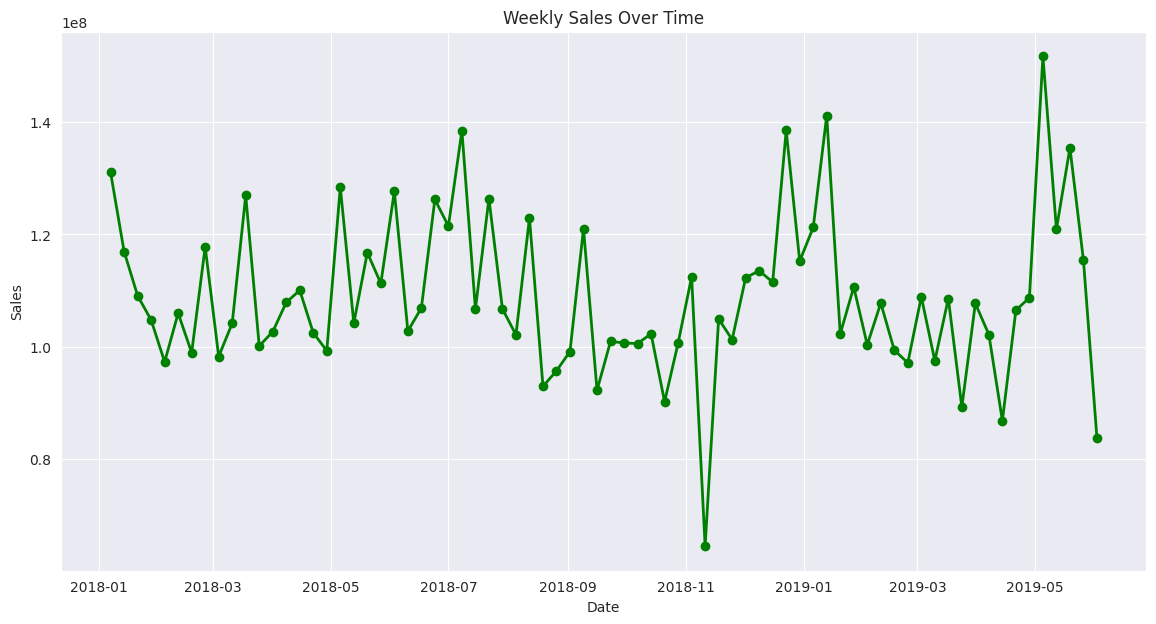

In [ ]:
sns.set_style('darkgrid')
# Aggregate weekly sales
weekly_sales = daily_sales['Sales'].resample('W').sum()

# Plotting the weekly time series
plt.figure(figsize=(14, 7))
plt.plot(weekly_sales.index, weekly_sales, color='green', marker = "o", linewidth=2)
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


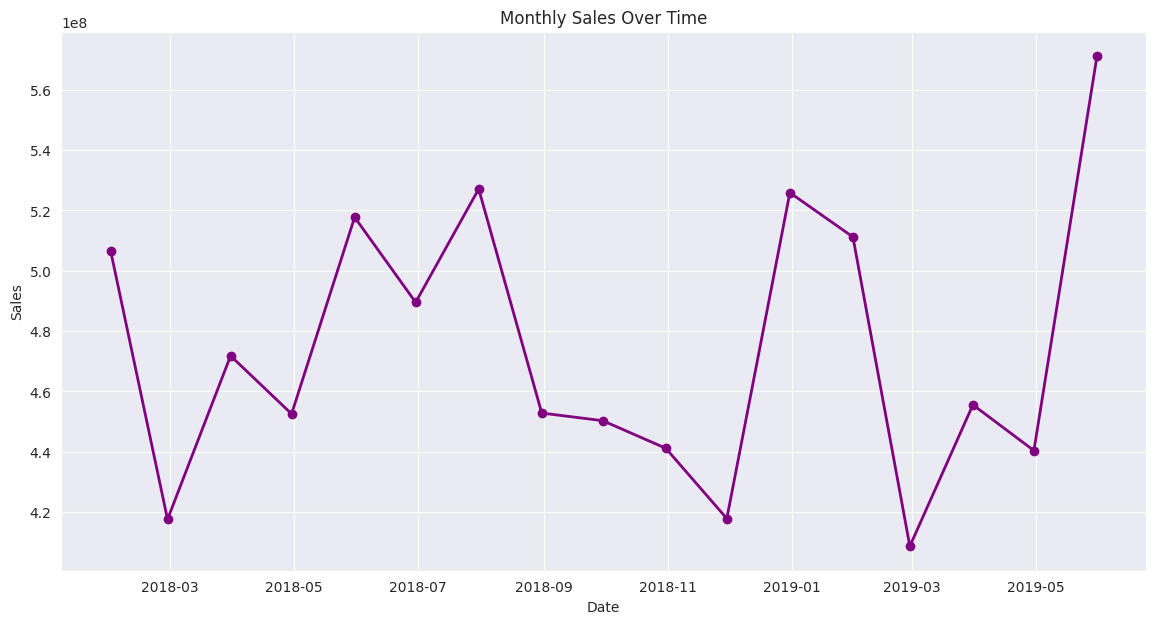

In [ ]:
sns.set_style('darkgrid')
# Aggregate monthly sales
monthly_sales = daily_sales['Sales'].resample('M').sum()

# Plotting the monthly time series
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, monthly_sales, color='purple', marker = 'o', linewidth=2)
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


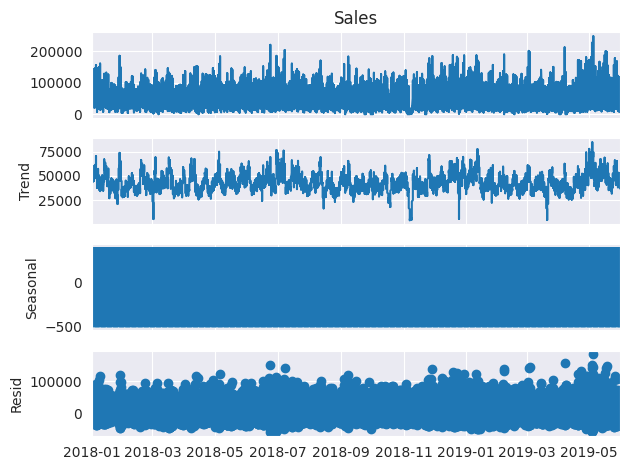

In [ ]:
# Perform seasonal decomposition using STL
stl = sm.tsa.seasonal_decompose(daily_sales['Sales'], model='additive', period=30)  # assuming monthly seasonality
result = stl.plot()
plt.show()

# **Hypothesis testing**

### **Transformation**

**Log Transformation**

In [ ]:
# Adding a small constant (1) before taking the log to handle zeros
df['non_zero_sales'] = df['Sales_capped']
df['non_zero_sales'] = df['non_zero_sales'].apply(lambda x: x + 0.01)

# Log Trasformation
df['Log_Sales'] = np.log(df['non_zero_sales'])

# Check for any remaining NaNs or infs
print("Number of NaNs or infs in Log_Sales:", np.isinf(df['Log_Sales']).sum() + np.isnan(df['Log_Sales']).sum())

Number of NaNs or infs in Log_Sales: 0


**Boxcox Transformation**

In [ ]:
# Apply Box-Cox transformation
df['Boxcox_Sales'], lambda_value = boxcox(df['non_zero_sales'])
print(f"Lambda for Sales: {lambda_value}")

Lambda for Sales: 0.4723455933955206


In [ ]:
df.head(2)

ID Store_id Store_Type Location_Type Region_Code       Date Holiday  \
0  T1000001        1         S1            L3          R1 2018-01-01       1   
1  T1000002      253         S4            L2          R1 2018-01-01       1   

  Discount  #Order     Sales  ... Quarter Day Week Day of Week Is_Weekend  \
0      Yes       9   7011.84  ...       1   1    1      Monday          0   
1      Yes      60  51789.12  ...       1   1    1      Monday          0   

      AOV Sales_capped  non_zero_sales  Log_Sales  Boxcox_Sales  
0  779.09      7011.84         7011.85   8.855357    136.655026  
1  863.15     51789.12        51789.13  10.854936    354.736412  

[2 rows x 22 columns]

### **Test for Normality**

p-value for shapiro: 1.4902777465932337e-133
p-value for KS-Test: 0.0



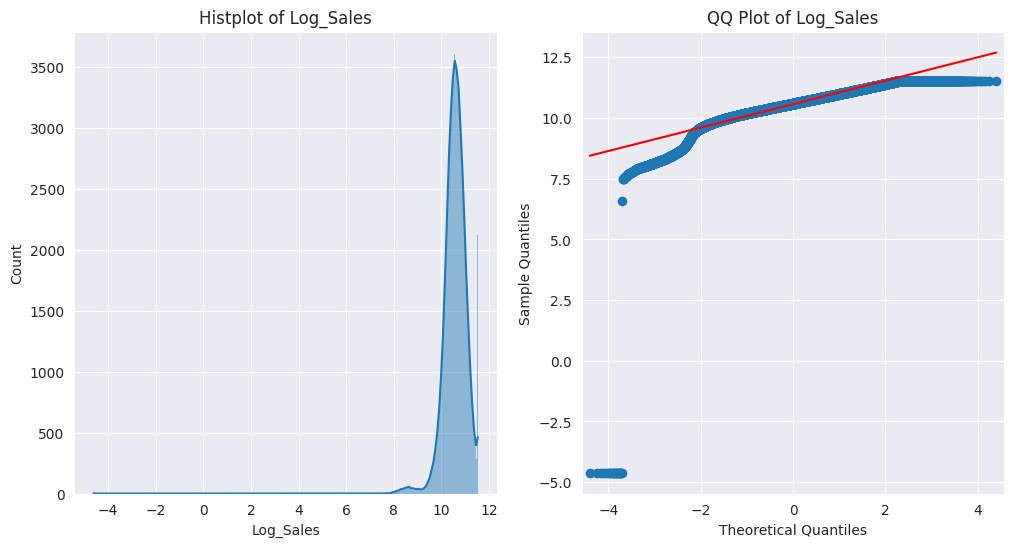

In [ ]:
p_value_shapiro = shapiro(df['Log_Sales'])[1]
p_value_ks = kstest(df['Log_Sales'], 'norm')[1]

print(f"p-value for shapiro: {p_value_shapiro}")
print(f"p-value for KS-Test: {p_value_ks}")
print()


plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(df['Log_Sales'], kde=True);
plt.title('Histplot of Log_Sales');

plt.subplot(1,2,2)
sm.qqplot(df['Log_Sales'], line='s', ax=plt.gca());
plt.title('QQ Plot of Log_Sales');

p-value for shapiro: 1.9410619805834166e-69
p-value for KS-Test: 0.0



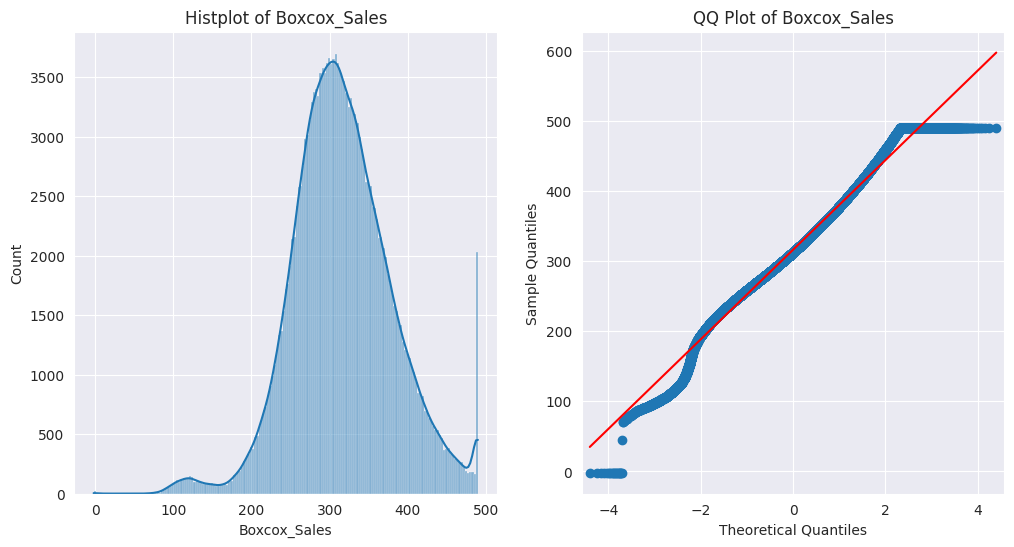

In [ ]:
p_value_shapiro = shapiro(df['Boxcox_Sales'])[1]
p_value_ks = kstest(df['Boxcox_Sales'], 'norm')[1]

print(f"p-value for shapiro: {p_value_shapiro}")
print(f"p-value for KS-Test: {p_value_ks}")
print()

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(df['Boxcox_Sales'], kde=True);
plt.title('Histplot of Boxcox_Sales');

plt.subplot(1,2,2)
sm.qqplot(df['Boxcox_Sales'], line='s', ax=plt.gca());
plt.title('QQ Plot of Boxcox_Sales');

### **Hypothesis 1: Effect of Holidays on Sales**

- $H_0$: Sales on holidays are same compared to non-holidays.
- $H_a$: Sales on holidays are higher compared to non-holidays.

In [ ]:
# Separate sales data into holidays and non-holidays
holiday_sales = df[df['Holiday'] == 1]['Boxcox_Sales']
non_holiday_sales = df[df['Holiday'] == 0]['Boxcox_Sales']
print(f"No of Observation in Holiday Sales: {len(holiday_sales)}\nNo of Observation in Non-holiday Sales: {len(non_holiday_sales)}")

No of Observation in Holiday Sales: 24820
No of Observation in Non-holiday Sales: 163520


In [ ]:
print("Mean on Holiday: {:.2f} and Mean on Non-holiday: {:.2f}".format(holiday_sales.mean(), non_holiday_sales.mean()))

Mean on Holiday: 284.42 and Mean on Non-holiday: 321.12


In [ ]:
print("Variance on Holiday: {:.2f} and Variance on Non-holiday: {:.2f}".format(holiday_sales.var(), non_holiday_sales.var()))

Variance on Holiday: 6065.52 and Variance on Non-holiday: 3608.44


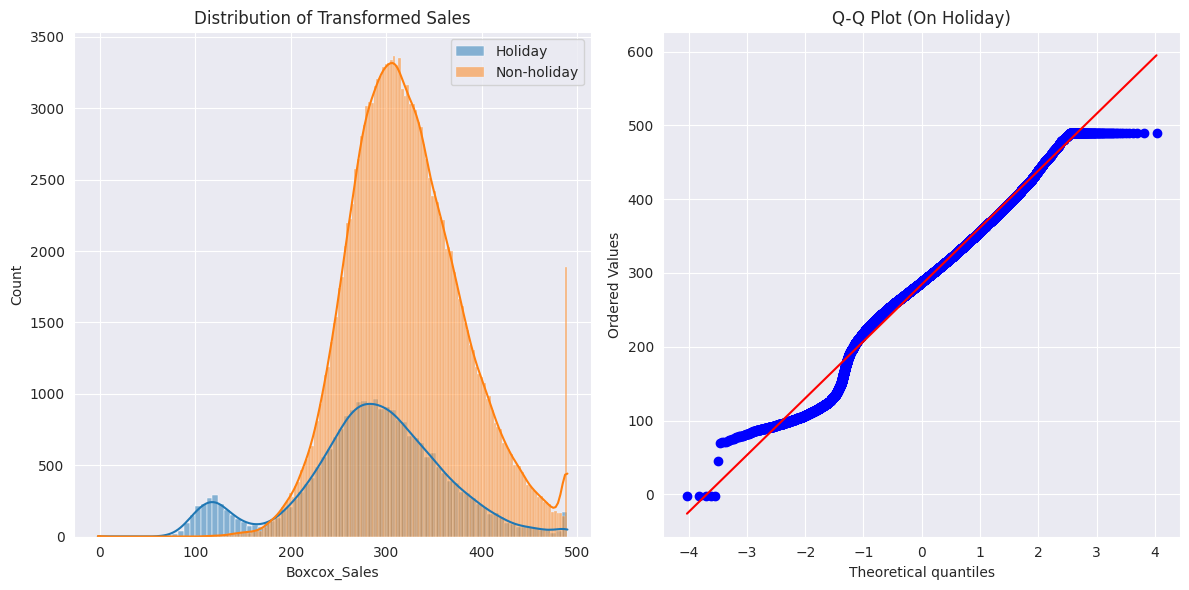

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(holiday_sales, kde=True, label='Holiday')
sns.histplot(non_holiday_sales, kde=True, label='Non-holiday')
plt.title('Distribution of Transformed Sales')
plt.legend()

plt.subplot(1, 2, 2)
probplot(holiday_sales, dist="norm", plot=plt)
plt.title('Q-Q Plot (On Holiday)')
plt.tight_layout()
plt.show()

In [ ]:
# Perform t-test
t_stat, p_val = ttest_ind(holiday_sales, non_holiday_sales, equal_var= False, alternative='less')
print(f"T-test for Holiday Impact on Sales: t-statistic = {t_stat:.2f}, p-value = {p_val:.2f}")

if p_val < 0.05:
  print("Reject the null hypothesis. Holiday has impact on Sales")
else:
  print("Fail to reject the null hypothesis. Holiday has no impact on Sales")

T-test for Holiday Impact on Sales: t-statistic = -71.10, p-value = 0.00
Reject the null hypothesis. Holiday has impact on Sales


In [ ]:
# Effect size (Cohen's d)
d = (np.mean(holiday_sales) - np.mean(non_holiday_sales)) / np.sqrt((np.std(holiday_sales, ddof=1) ** 2 + np.std(non_holiday_sales, ddof=1) ** 2) / 2)
print(f"Cohen's d: {d:.2f}")


# Non-parametric test
u_statistic, p_value_mw = mannwhitneyu(holiday_sales, non_holiday_sales, alternative='less')
print(f"Mann-Whitney U p-value: {p_value_mw}")

Cohen's d: -0.53
Mann-Whitney U p-value: 0.0


**Insight:**

---

- <font color=blue>Above test suggest to reject the Null hypothesis. Thus, Holiday has an impact on Sales.

---

### **Hypothesis 2: Effect of Discount on Sales**

- $H_0$: Stores offering discounts have same sales as stores not offering discounts.

- $H_1$: Stores offering discounts have significantly higher sales than stores not offering discounts.

In [ ]:
# Separate sales data into discount and non-discount
discount_sales = df[df['Discount'] == 'Yes']['Boxcox_Sales']
non_discount_sales = df[df['Discount'] == 'No']['Boxcox_Sales']
print(f"No of Observation in Discount Sales: {len(discount_sales)}\nNo of Observation in Non-Discount Sales: {len(non_discount_sales)}")

No of Observation in Discount Sales: 84289
No of Observation in Non-Discount Sales: 104051


In [ ]:
print("Mean with Discount: {:.2f} and Mean withount discount: {:.2f}".format(discount_sales.mean(), non_discount_sales.mean()))

Mean with Discount: 340.15 and Mean withount discount: 296.95


In [ ]:
print("Variance with Discount: {:.2f} and Variance withount discount: {:.2f}".format(discount_sales.var(), non_discount_sales.var()))

Variance with Discount: 3614.56 and Variance withount discount: 3633.23


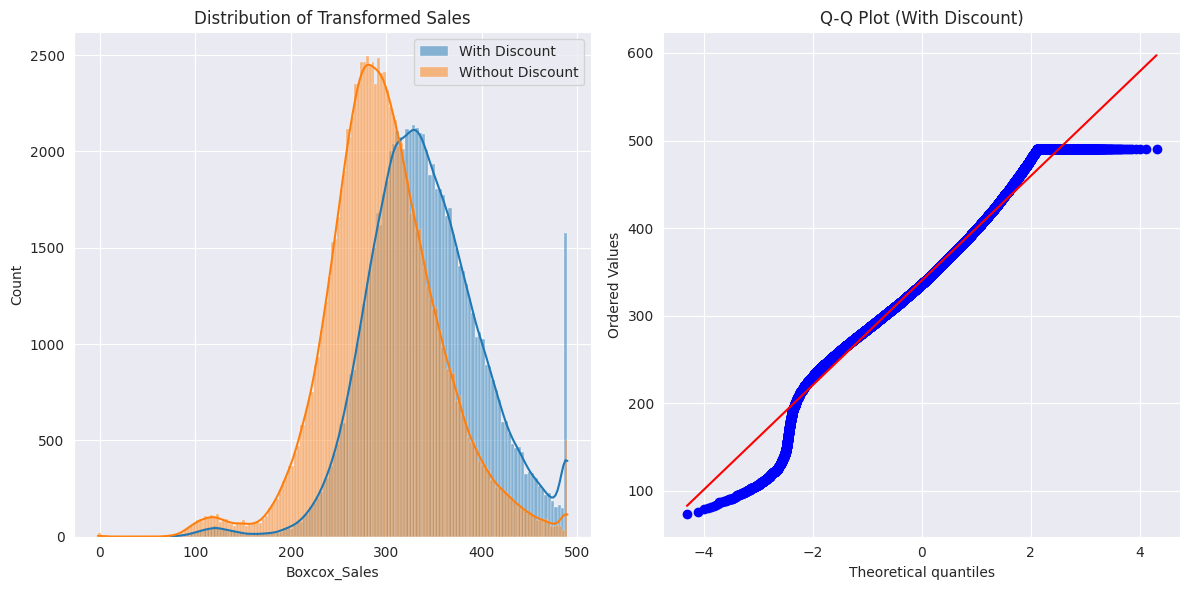

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(discount_sales, kde=True, label='With Discount')
sns.histplot(non_discount_sales, kde=True, label='Without Discount')
plt.title('Distribution of Transformed Sales')
plt.legend()

plt.subplot(1, 2, 2)
probplot(discount_sales, dist="norm", plot=plt)
plt.title('Q-Q Plot (With Discount)')
plt.tight_layout()
plt.show()

In [ ]:
# Perform t-test
t_stat, p_val = ttest_ind(discount_sales, non_discount_sales, equal_var = False, alternative='greater')
print(f"T-test for Discount Impact on Sales:\nt-statistic = {t_stat:.2f},\np-value = {p_val:.2f}")

if p_val < 0.05:
  print("Reject the null hypothesis. Discount has an impact on Sales")
else:
  print("Fail to reject the null hypothesis. Discount has no impact on Sales")

T-test for Discount Impact on Sales:
t-statistic = 154.89,
p-value = 0.00
Reject the null hypothesis. Discount has an impact on Sales


In [ ]:
# Effect size (Cohen's d)
d = (np.mean(discount_sales) - np.mean(non_discount_sales)) / np.sqrt((np.std(discount_sales, ddof=1) ** 2 + np.std(non_discount_sales, ddof=1) ** 2) / 2)
print(f"Cohen's d: {d:.2f}")


# Non-parametric test
u_statistic, p_value_mw = mannwhitneyu(discount_sales, non_discount_sales, alternative='greater')
print(f"Mann-Whitney U p-value: {p_value_mw}")

Cohen's d: 0.72
Mann-Whitney U p-value: 0.0


**Insight:**

---

- <font color=blue>Above test suggest to reject the Null hypothesis. Thus, Discount has an impact on Sales.

---

### **Hypothesis 3: Store Type impacts Sales**

- $H_0$: All Store types have similar sales.
- $H_a$: At least one store type have different sales.

In [ ]:
store_types = sorted(df.Store_Type.unique())
store_types

['S1', 'S2', 'S3', 'S4']

In [ ]:
s1 = df[df['Store_Type'] == 'S1']['Boxcox_Sales']
s2 = df[df['Store_Type'] == 'S2']['Boxcox_Sales']
s3 = df[df['Store_Type'] == 'S3']['Boxcox_Sales']
s4 = df[df['Store_Type'] == 'S4']['Boxcox_Sales']

In [ ]:
## Anova Test
f_stats, p_value = f_oneway(s1, s2, s3, s4)

if p_value < 0.05:
    print("Reject the null hypothesis (H0): At lease one of the store types have different sales.")
else:
    print("Fail to reject the null hypothesis (H0): All store types have the same sales.")

Reject the null hypothesis (H0): At lease one of the store types have different sales.


In [ ]:
## Kruskal Test: As we do not have normal distribution
f_stats, p_value = kruskal(s1, s2, s3, s4)

if p_value < 0.05:
    print("Reject the null hypothesis (H0): At lease one of the store types have different sales.")
else:
    print("Fail to reject the null hypothesis (H0): All store types have the same sales.")

Reject the null hypothesis (H0): At lease one of the store types have different sales.


In [ ]:
# Post-hoc analysis
store_types_sales = [s1, s2, s3, s4]

for i in range(4):
  for j in range(i+1, 4):
    t_stat, p_value = ttest_ind(store_types_sales[i], store_types_sales[j], equal_var=False)
    print(f"T-test for {store_types[i]} and {store_types[j]}: t-statistic = {t_stat:.2f}, p-value = {p_value:.2f}")

    if p_value < 0.05:
      print(f"Reject the null hypothesis (H0) for {store_types[i]} and {store_types[j]}")
    else:
      print(f"Fail to reject the null hypothesis (H0) for {store_types[i]} and {store_types[j]}")
    print()

T-test for S1 and S2: t-statistic = 138.32, p-value = 0.00
Reject the null hypothesis (H0) for S1 and S2

T-test for S1 and S3: t-statistic = -91.24, p-value = 0.00
Reject the null hypothesis (H0) for S1 and S3

T-test for S1 and S4: t-statistic = -224.97, p-value = 0.00
Reject the null hypothesis (H0) for S1 and S4

T-test for S2 and S3: t-statistic = -180.84, p-value = 0.00
Reject the null hypothesis (H0) for S2 and S3

T-test for S2 and S4: t-statistic = -303.57, p-value = 0.00
Reject the null hypothesis (H0) for S2 and S4

T-test for S3 and S4: t-statistic = -89.59, p-value = 0.00
Reject the null hypothesis (H0) for S3 and S4



**Insight:**

---

- <font color=blue>Above test suggest to reject the Null hypothesis. And Post-hoc suggests, all the store type have different sales.  

---

### **Hypothesis 4: Region impacts Sales**

- $H_0$: All regions have similar sales.
- $H_a$: At least one region have different sales.

In [ ]:
regions = df.Region_Code.unique()
regions

['R1', 'R4', 'R2', 'R3']
Categories (4, object): ['R1', 'R2', 'R3', 'R4']

In [ ]:
r1 = df[df['Region_Code'] == 'R1']['Boxcox_Sales']
r2 = df[df['Region_Code'] == 'R2']['Boxcox_Sales']
r3 = df[df['Region_Code'] == 'R3']['Boxcox_Sales']
r4 = df[df['Region_Code'] == 'R4']['Boxcox_Sales']

In [ ]:
## Anova Test
f_stats, p_value = f_oneway(r1, r2, r3, r4)

if p_value < 0.05:
    print("Reject the null hypothesis (H0): At lease one of the regions have different sales.")
else:
    print("Fail to reject the null hypothesis (H0): All regions have the same sales.")

Reject the null hypothesis (H0): At lease one of the regions have different sales.


In [ ]:
## Kruskal Test: As we do not have normal distribution
f_stats, p_value = kruskal(r1, r2, r3, r4)

if p_value < 0.05:
    print("Reject the null hypothesis (H0): At lease one of the regions have different sales.")
else:
    print("Fail to reject the null hypothesis (H0): All regions have the same sales.")

Reject the null hypothesis (H0): At lease one of the regions have different sales.


In [ ]:
# Post-hoc analysis
regions_sales = [r1, r2, r3, r4]

for i in range(4):
  for j in range(i+1, 4):
    t_stat, p_value = ttest_ind(regions_sales[i], regions_sales[j], equal_var=False)
    print(f"T-test for {regions[i]} and {regions[j]}: t-statistic = {t_stat:.2f}, p-value = {p_value:.2f}")
    if p_value < 0.05:
      print(f"Reject the null hypothesis (H0) for {regions[i]} and {regions[j]}")
    else:
      print(f"Fail to reject the null hypothesis (H0) for {regions[i]} and {regions[j]}")
    print()

T-test for R1 and R4: t-statistic = 56.58, p-value = 0.00
Reject the null hypothesis (H0) for R1 and R4

T-test for R1 and R2: t-statistic = 33.99, p-value = 0.00
Reject the null hypothesis (H0) for R1 and R2

T-test for R1 and R3: t-statistic = 48.49, p-value = 0.00
Reject the null hypothesis (H0) for R1 and R3

T-test for R4 and R2: t-statistic = -20.96, p-value = 0.00
Reject the null hypothesis (H0) for R4 and R2

T-test for R4 and R3: t-statistic = 1.84, p-value = 0.07
Fail to reject the null hypothesis (H0) for R4 and R3

T-test for R2 and R3: t-statistic = 19.13, p-value = 0.00
Reject the null hypothesis (H0) for R2 and R3



**Insight:**

---

- <font color=blue>Above test suggest to reject the Null hypothesis. And Post-hoc analysis suggests, all the regions have different sales **except R2 and R4**.  

---

### **Hypothesis 5: Location_type impacts Sales**

- $H_0$: All locations have similar sales.
- $H_a$: At least one location have different sales.

In [ ]:
location_types = sorted(df.Location_Type.unique())
location_types

['L1', 'L2', 'L3', 'L4', 'L5']

In [ ]:
l1 = df[df['Location_Type'] == 'L1']['Boxcox_Sales']
l2 = df[df['Location_Type'] == 'L2']['Boxcox_Sales']
l3 = df[df['Location_Type'] == 'L3']['Boxcox_Sales']
l4 = df[df['Location_Type'] == 'L4']['Boxcox_Sales']
l5 = df[df['Location_Type'] == 'L5']['Boxcox_Sales']

In [ ]:
## Anova Test
f_stats, p_value = f_oneway(l1, l2, l3, l4, l5)

if p_value < 0.05:
    print("Reject the null hypothesis (H0): At lease one of the location types have different sales.")
else:
    print("Fail to reject the null hypothesis (H0): All location types have the same sales.")

Reject the null hypothesis (H0): At lease one of the location types have different sales.


In [ ]:
## Kruskal Test: As we do not have normal distribution
f_stats, p_value = kruskal(l1, l2, l3, l4, l5)

if p_value < 0.05:
    print("Reject the null hypothesis (H0): At lease one of the location types have different sales.")
else:
    print("Fail to reject the null hypothesis (H0): All location types have the same sales.")

Reject the null hypothesis (H0): At lease one of the location types have different sales.


In [ ]:
# Post-hoc analysis
loc_sales = [l1, l2, l3, l4, l5]
for i in range(len(location_types)):
  for j in range(i+1, len(location_types)):
    t_stat, p_value = ttest_ind(loc_sales[i], loc_sales[j], equal_var=False)
    print(f"T-test for {location_types[i]} and {location_types[j]}: t-statistic = {t_stat:.2f}, p-value = {p_value:.2f}")
    if p_value < 0.05:
      print(f"Reject the null hypothesis (H0) for {location_types[i]} and {location_types[j]}")
    else:
      print(f"Fail to reject the null hypothesis (H0) for {location_types[i]} and {location_types[j]}")
    print()

T-test for L1 and L2: t-statistic = -176.30, p-value = 0.00
Reject the null hypothesis (H0) for L1 and L2

T-test for L1 and L3: t-statistic = 101.71, p-value = 0.00
Reject the null hypothesis (H0) for L1 and L3

T-test for L1 and L4: t-statistic = 110.82, p-value = 0.00
Reject the null hypothesis (H0) for L1 and L4

T-test for L1 and L5: t-statistic = 161.83, p-value = 0.00
Reject the null hypothesis (H0) for L1 and L5

T-test for L2 and L3: t-statistic = 234.94, p-value = 0.00
Reject the null hypothesis (H0) for L2 and L3

T-test for L2 and L4: t-statistic = 216.47, p-value = 0.00
Reject the null hypothesis (H0) for L2 and L4

T-test for L2 and L5: t-statistic = 266.57, p-value = 0.00
Reject the null hypothesis (H0) for L2 and L5

T-test for L3 and L4: t-statistic = 34.61, p-value = 0.00
Reject the null hypothesis (H0) for L3 and L4

T-test for L3 and L5: t-statistic = 76.46, p-value = 0.00
Reject the null hypothesis (H0) for L3 and L5

T-test for L4 and L5: t-statistic = 33.45, p-va

**Insight:**

---

- <font color=blue>Above test suggest to reject the Null hypothesis. And Post-hoc analysis suggests, all the location types have different sales.  

---

### **Hypothesis 6: Number of Orders and Sales**

- $H_0$: There is no correlation between the number of orders and sales.
- $H_a$: There is a correlation between the number of orders and sales.

In [ ]:
from scipy.stats import pearsonr, spearmanr

# As data is not normally distributed, using Spearman correlation
corr_coef, p_value = spearmanr(df['#Order'], df['Sales'])

print(f"Spearman Correlation Coefficient: {corr_coef}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject H0: The correlation is statistically significant. Number of Orders and Sales are correlated")
else:
    print("Fail to Reject H0: The correlation is not statistically significant. Number of Orders and Sales are correlated")

Spearman Correlation Coefficient: 0.9377462542885381
P-value: 0.0
Reject H0: The correlation is statistically significant. Number of Orders and Sales are correlated


**Insight:**

---

- <font color=blue>Above test suggested to reject the Null hypothesis. #Orders and Sales are correlated. Thus, higher #Orders referes to. higher sales.

---

### **Hypothesis 7: Impact of Day of the Week on Sales:**

- Null Hypothesis (H0): There is no significant difference in sales across different days of the week.
- Alternate Hypothesis (H1): There is a significant difference in sales across different days of the week.

In [ ]:
# ANOVA test
mon = df[df['Day of Week'] == 'Monday']['Sales']
tue = df[df['Day of Week'] == 'Tuesday']['Sales']
wed = df[df['Day of Week'] == 'Wednesday']['Sales']
thu = df[df['Day of Week'] == 'Thursday']['Sales']
fri = df[df['Day of Week'] == 'Friday']['Sales']
sat = df[df['Day of Week'] == 'Saturday']['Sales']
sun = df[df['Day of Week'] == 'Sunday']['Sales']

anova_day = f_oneway(mon,tue,wed, thu, fri, sat, sun)

print(f"ANOVA test for Day of the Week on Sales: F-statistic = {anova_day.statistic:.2f}, p-value = {anova_day.pvalue:.2f}")

ANOVA test for Day of the Week on Sales: F-statistic = 1066.17, p-value = 0.00


**Insight:**

---

- <font color=blue>Since the p-value is much less than the significance level (typically 0.05), we reject the null hypothesis. This means that there is a significant difference in sales across different days of the week.

---

In [ ]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [ ]:
day_sales = [mon,tue,wed, thu, fri, sat, sun]
ind = 0
for i in day_sales:
  print(f"{days[ind]}: Mean: {i.mean():.0f} and Variance: {i.var():.0f} ")
  ind += 1

Monday: Mean: 42291 and Variance: 287558689 
Tuesday: Mean: 40803 and Variance: 281987390 
Wednesday: Mean: 40827 and Variance: 299633780 
Thursday: Mean: 40232 and Variance: 313867442 
Friday: Mean: 39701 and Variance: 307197896 
Saturday: Mean: 46730 and Variance: 398001576 
Sunday: Mean: 49044 and Variance: 420195042 


In [ ]:
## Post-hoc Analysis

day_sales = [mon,tue,wed, thu, fri, sat, sun]

for i in range(len(day_sales)):
  for j in range(i+1, len(day_sales)):
    t_stat, p_value = ttest_ind(day_sales[i], day_sales[j], equal_var=False)

    print(f"T-test for {days[i]} and {days[j]}: t-statistic = {t_stat:.2f}, p-value = {p_value:.2f}")
    if p_value < 0.05:
      print(f"Reject the null hypothesis (H0) for {days[i]} and {days[j]}")
    else:
      print(f"Fail to reject the null hypothesis (H0) for {days[i]} and {days[j]}")
    print()

T-test for Monday and Tuesday: t-statistic = 10.25, p-value = 0.00
Reject the null hypothesis (H0) for Monday and Tuesday

T-test for Monday and Wednesday: t-statistic = 9.93, p-value = 0.00
Reject the null hypothesis (H0) for Monday and Wednesday

T-test for Monday and Thursday: t-statistic = 13.80, p-value = 0.00
Reject the null hypothesis (H0) for Monday and Thursday

T-test for Monday and Friday: t-statistic = 17.45, p-value = 0.00
Reject the null hypothesis (H0) for Monday and Friday

T-test for Monday and Saturday: t-statistic = -27.75, p-value = 0.00
Reject the null hypothesis (H0) for Monday and Saturday

T-test for Monday and Sunday: t-statistic = -41.55, p-value = 0.00
Reject the null hypothesis (H0) for Monday and Sunday

T-test for Tuesday and Wednesday: t-statistic = -0.17, p-value = 0.87
Fail to reject the null hypothesis (H0) for Tuesday and Wednesday

T-test for Tuesday and Thursday: t-statistic = 3.84, p-value = 0.00
Reject the null hypothesis (H0) for Tuesday and Thur

**Insight:**

---

- <font color=blue>Sales on each days are differnt except Tuesday and Wednesday.

---

### **Hypothesis 8: Weekend vs Weekday Sales**

- Null Hypothesis (H0): There is no significant difference in sales on weekends and on weekdays.
- Alternate Hypothesis (H1): There is a significant difference in sales on weekends and on weekdays.

In [ ]:
weekend = df[df['Is_Weekend'] == 1]['Sales']
weekday = df[df['Is_Weekend'] == 0]['Sales']

In [ ]:
print("Mean on Weekend: {:.2f} and Mean on Weekday: {:.2f}".format(weekend.mean(), weekday.mean()))
print("Variance on Weekend: {:.2f} and Variance on Weekday: {:.2f}".format(weekend.var(), weekday.var()))

Mean on Weekend: 47886.93 and Mean on Weekday: 40770.87
Variance on Weekend: 410429599.89 and Variance on Weekday: 298790318.78


In [ ]:
t_stats, p_value = ttest_ind(weekend, weekday, equal_var=False, alternative='greater')
print(f"T-test for Weekend vs Weekday Sales: t-statistic = {t_stats:.2f}, p-value = {p_value:.2f}")

if p_value < 0.05:
  print("Reject the null hypothesis. Weekend has impact on Sales")
else:
  print("Fail to reject the null hypothesis. Weekend has no impact on Sales")

T-test for Weekend vs Weekday Sales: t-statistic = 71.47, p-value = 0.00
Reject the null hypothesis. Weekend has impact on Sales


**Insight:**

---

- <font color=blue>Null hypothesis rejected. Weekend has impact on Sales

---

### **Hypothesis 9: Impact of Month on Sales**

- Null Hypothesis (H0): There is no significant difference in sales across different months.
- Alternate Hypothesis (H1): There is a significant difference in sales across different months.

In [ ]:
# Filter data for 2018, excluding 2019 as we do not have full year data and that could create bias
df_2018 = df[df['Year'] == 2018]

# ANOVA test
anova_month = stats.f_oneway(
    df_2018[df_2018['Month'] == 1]['Sales'],
    df_2018[df_2018['Month'] == 2]['Sales'],
    df_2018[df_2018['Month'] == 3]['Sales'],
    df_2018[df_2018['Month'] == 4]['Sales'],
    df_2018[df_2018['Month'] == 5]['Sales'],
    df_2018[df_2018['Month'] == 6]['Sales'],
    df_2018[df_2018['Month'] == 7]['Sales'],
    df_2018[df_2018['Month'] == 8]['Sales'],
    df_2018[df_2018['Month'] == 9]['Sales'],
    df_2018[df_2018['Month'] == 10]['Sales'],
    df_2018[df_2018['Month'] == 11]['Sales'],
    df_2018[df_2018['Month'] == 12]['Sales']
)

print(f"ANOVA test for Month on Sales (2018 data only): F-statistic = {anova_month.statistic:.2f}, p-value = {anova_month.pvalue:.2f}")


ANOVA test for Month on Sales (2018 data only): F-statistic = 311.66, p-value = 0.00


**Insight:**

---

- <font color=blue>Since the p-value is much less than the significance level (typically 0.05), we reject the null hypothesis. This means that there is a significant difference in sales across different months of 2018.

---

### **Hypothesis 10: Effect of Holidays and Discounts Combined on Sales**

- Null Hypothesis (H0): There is no significant interaction effect between holidays and discounts on sales.
- Alternate Hypothesis (H1): There is a significant interaction effect between holidays and discounts on sales.

In [ ]:
# Two-way ANOVA
model = ols('Sales ~ C(Holiday) * C(Discount)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                              sum_sq        df             F        PR(>F)
C(Holiday)              1.665933e+12       1.0   5638.937437  0.000000e+00
C(Discount)             6.860058e+12       1.0  23220.282447  0.000000e+00
C(Holiday):C(Discount)  1.198094e+11       1.0    405.537200  4.272838e-90
Residual                5.564084e+13  188336.0           NaN           NaN


**Insight:**

---

- <font color=blue>Since the p-value is much less than the significance level (typically 0.05), we reject the null hypothesis. This means that there is a significant impact of Holiday, Discount, and Holiday and Discount combined on sales.

---

# **ML Modeling**

In [ ]:
train_sales_transformed = df.copy()
train_sales_transformed.head(2)

ID Store_id Store_Type Location_Type Region_Code       Date Holiday  \
0  T1000001        1         S1            L3          R1 2018-01-01       1   
1  T1000002      253         S4            L2          R1 2018-01-01       1   

  Discount  #Order     Sales  ... Quarter Day Week Day of Week Is_Weekend  \
0      Yes       9   7011.84  ...       1   1    1      Monday          0   
1      Yes      60  51789.12  ...       1   1    1      Monday          0   

      AOV Sales_capped  non_zero_sales  Log_Sales  Boxcox_Sales  
0  779.09      7011.84         7011.85   8.855357    136.655026  
1  863.15     51789.12        51789.13  10.854936    354.736412  

[2 rows x 22 columns]

## **Data Processing**

### **Data Cleaning**

In [ ]:
## Checking if we have missing data for any date
df.shape[0] == df.Date.nunique() * df.Store_id.nunique()

True

**We don't have missing data/seqence**

In [ ]:
# Check for duplicates
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# Remove duplicates if any
df = df.drop_duplicates()

Number of duplicate rows: 0


**There are no duplicates.**

### **Feature Extraction and Selection**

In [ ]:
df.head(2)

ID Store_id Store_Type Location_Type Region_Code       Date Holiday  \
0  T1000001        1         S1            L3          R1 2018-01-01       1   
1  T1000002      253         S4            L2          R1 2018-01-01       1   

  Discount  #Order     Sales  ... Quarter Day Week Day of Week Is_Weekend  \
0      Yes       9   7011.84  ...       1   1    1      Monday          0   
1      Yes      60  51789.12  ...       1   1    1      Monday          0   

      AOV Sales_capped  non_zero_sales  Log_Sales  Boxcox_Sales  
0  779.09      7011.84         7011.85   8.855357    136.655026  
1  863.15     51789.12        51789.13  10.854936    354.736412  

[2 rows x 22 columns]

In [ ]:
df.columns

Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', '#Order', 'Sales', 'Year', 'Month', 'Quarter',
       'Day', 'Week', 'Day of Week', 'Is_Weekend', 'AOV', 'Sales_capped',
       'non_zero_sales', 'Log_Sales', 'Boxcox_Sales'],
      dtype='object')

In [ ]:
## Checking if Store_id is uniquely associated with 'Store_Type', 'Location_Type', and 'Region_Code'
df.groupby(['Store_id'])[['Store_Type',
                          'Location_Type',
                          'Region_Code']].nunique().sort_values(by=['Store_Type',
                                                                    'Location_Type',
                                                                    'Region_Code'], ascending =False).head(2)

Store_Type  Location_Type  Region_Code
Store_id                                        
1                  1              1            1
2                  1              1            1

In [ ]:
col_to_drop = ['ID', 'Store_id', 'Date', '#Order','Sales', 'Is_Weekend','AOV', 'non_zero_sales',
               'Log_Sales', 'Boxcox_Sales']

train_df = df.drop(columns=col_to_drop)
train_df.head(2)

Store_Type Location_Type Region_Code Holiday Discount  Year Month Quarter  \
0         S1            L3          R1       1      Yes  2018     1       1   
1         S4            L2          R1       1      Yes  2018     1       1   

  Day Week Day of Week  Sales_capped  
0   1    1      Monday       7011.84  
1   1    1      Monday      51789.12

- `ID` will be dropped as it is not useful for the model
- `Store_id` is associated with `Store_type`, `Location_Type`, and `Region_Code`. If we take `Store_id`, other three mentioned feature will be redundent.
- `Date` will be dropped as model will not take datetime variable. extracted date features are kept
- Will do aggregation on `Date` so, `Store_id` will be dropped
- 'non_zero_sales', 'Log_Sales', 'Boxcox_Sales' to be dropped
- Will use 'Sales_capped' so 'Sales' Column will be dropped  
- `#Order` is highly correlated with Sales. No need to keep this as test set will not have `#Order`
- `Is_weekend` and `Day of Week` are for the same purpose, no need to keep both

### **Data Transformation and Encoding**

#### **One-hot Encoding**

In [ ]:
# One-Hot Encoding for Store_Type, Location_Type, Region_Code, and Day_of_Week
train_df = pd.get_dummies(train_df, columns=['Store_Type', "Location_Type", "Region_Code",
                                             "Year", "Month", "Quarter", "Week", "Day",'Day of Week'], drop_first=True, dtype=int)

#### **Label Encoding**

In [ ]:
## Label Encoding
train_df['Discount'] = train_df['Discount'].map({'No': 0, 'Yes': 1})

In [ ]:
train_df.columns

Index(['Holiday', 'Discount', 'Sales_capped', 'Store_Type_S2', 'Store_Type_S3',
       'Store_Type_S4', 'Location_Type_L2', 'Location_Type_L3',
       'Location_Type_L4', 'Location_Type_L5',
       ...
       'Day_28', 'Day_29', 'Day_30', 'Day_31', 'Day of Week_Monday',
       'Day of Week_Saturday', 'Day of Week_Sunday', 'Day of Week_Thursday',
       'Day of Week_Tuesday', 'Day of Week_Wednesday'],
      dtype='object', length=115)

### **Train Test Split**

In [ ]:
train_df.head(2)

Holiday Discount  Sales_capped  Store_Type_S2  Store_Type_S3  Store_Type_S4  \
0       1        1       7011.84              0              0              0   
1       1        1      51789.12              0              0              1   

   Location_Type_L2  Location_Type_L3  Location_Type_L4  Location_Type_L5  \
0                 0                 1                 0                 0   
1                 1                 0                 0                 0   

   ...  Day_28  Day_29  Day_30  Day_31  Day of Week_Monday  \
0  ...       0       0       0       0                   1   
1  ...       0       0       0       0                   1   

   Day of Week_Saturday  Day of Week_Sunday  Day of Week_Thursday  \
0                     0                   0                     0   
1                     0                   0                     0   

   Day of Week_Tuesday  Day of Week_Wednesday  
0                    0                      0  
1                    0                      0  

[2 rows x 115 columns]

In [ ]:
#### Splitting the Data
X = train_df.drop(columns=['Sales_capped'])
y = train_df['Sales_capped']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f"Train Shape: {X_train.shape}, {y_train.shape}"),
print(f"Validation Shape: {X_val.shape}, {y_val.shape}")

Train Shape: (150672, 114), (150672,)
Validation Shape: (37668, 114), (37668,)


## **Scaling**

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical features
X_train = scaler.fit_transform(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=X.columns)

X_val = scaler.transform(X_val)
X_val = pd.DataFrame(X_val, columns=X.columns)

In [ ]:
# Save the scaler
# with open('scaler.pkl', 'wb') as file:
#     pickle.dump(scaler, file)
# files.download('scaler.pkl')

## **Model Selection**

Step 2: Model Selection

Given the structure and type of data, we can consider the following models for forecasting:

1. **Linear Regression**: Simple and interpretable.
2. **Decision Tree Regression**: Can capture non-linear relationships.
3. **Random Forest Regression**: An ensemble method that usually provides better accuracy.


4. **Time Series Models** (e.g., ARIMA, Prophet): Specialized for time series data.


### **Model Training**

#### **Linear Regression: Baseline Mode**

In [ ]:
print(X_train.columns)

Index(['Holiday', 'Discount', 'Store_Type_S2', 'Store_Type_S3',
       'Store_Type_S4', 'Location_Type_L2', 'Location_Type_L3',
       'Location_Type_L4', 'Location_Type_L5', 'Region_Code_R2',
       ...
       'Day_28', 'Day_29', 'Day_30', 'Day_31', 'Day of Week_Monday',
       'Day of Week_Saturday', 'Day of Week_Sunday', 'Day of Week_Thursday',
       'Day of Week_Tuesday', 'Day of Week_Wednesday'],
      dtype='object', length=114)


In [ ]:
X_train.head(2)

Holiday  Discount  Store_Type_S2  Store_Type_S3  Store_Type_S4  \
0 -0.390308 -0.899978       2.344151      -0.388149      -0.566835   
1 -0.390308 -0.899978      -0.426594       2.576329      -0.566835   

   Location_Type_L2  Location_Type_L3  Location_Type_L4  Location_Type_L5  \
0         -0.589276          2.297675         -0.247562         -0.282789   
1         -0.589276         -0.435223         -0.247562         -0.282789   

   Region_Code_R2  ...    Day_28    Day_29    Day_30    Day_31  \
0       -0.637167  ... -0.185036 -0.174451 -0.172991 -0.141095   
1       -0.637167  ... -0.185036 -0.174451 -0.172991 -0.141095   

   Day of Week_Monday  Day of Week_Saturday  Day of Week_Sunday  \
0           -0.408087              2.461817           -0.406348   
1            2.450458             -0.406204           -0.406348   

   Day of Week_Thursday  Day of Week_Tuesday  Day of Week_Wednesday  
0             -0.409193             -0.41043              -0.408408  
1             -0.409193             -0.41043              -0.408408  

[2 rows x 114 columns]

In [ ]:
# # save csv
# X_train.to_csv('X_train.csv', index=False)
# files.download('X_train.csv')

In [ ]:
# with open('X_train.pkl', 'wb') as file:
#     pickle.dump(X_train, file)
# files.download('X_train.pkl')

In [ ]:
## Model Training
def model_lr(X_train,y_train):
    '''
    Fit the model and return the results
    '''
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

lr = model_lr(X_train, y_train)
lr

LinearRegression()

In [ ]:
## making predictions
def make_pred(model, X_train, X_test):
    '''
    returns a tuple of y_pred_train, y_pred_test
    '''
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    return y_pred_train, y_pred_test

## Adj R2 Function
def adj_r2(r2,n,k):
  return 1 - (((1-r2)*(n-1))/(n-k-1))

## Model Evaluation
def model_evaluation(model, X_train, y_train, X_test, y_test):

    '''
    Print model performance matrices and
    returns a dictionary of test predictions and model performance matrices list
    Attributes:
    test_prediction: array of test predictions
    model_performance_matrices: list(r2_train, r2_test, AdjR2_train, AdjR2_test, mae, mse, rmse, mape)

    '''
    y_pred_train, y_pred_test = make_pred(model, X_train, X_test)

    r2_train = r2_score(y_train, y_pred_train )
    r2_test = r2_score(y_test, y_pred_test)

    AdjR2_train = adj_r2(r2_train, X_train.shape[0], X_train.shape[1])
    AdjR2_test = adj_r2(r2_test, X_test.shape[0], X_test.shape[1])

    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred_test)

    model_matrices = {"Train_R2": r2_train,
                      "Test_R2": r2_test,
                      "Train_Adjested_R2": AdjR2_train,
                      "Test_Adjusted_R2": AdjR2_test,
                      "MAE": mae,
                      "MSE":mse,
                      "RMSE":rmse,
                      "MAPE":mape
                      }

    return {"test_predictions": y_pred_test,"model_performance_matrices":model_matrices}

In [ ]:
res = model_evaluation(lr, X_train, y_train, X_val, y_val)
res['model_performance_matrices']

{'Train_R2': 0.6532491461404953,
 'Test_R2': 0.6497829518841214,
 'Train_Adjested_R2': 0.6529865904483656,
 'Test_Adjusted_R2': 0.6487197946534019,
 'MAE': 7656.507436794796,
 'MSE': 110075769.2266917,
 'RMSE': 10491.700016045621,
 'MAPE': 8499192925803209.0}

**Insights**

___

**Interpretation of Linear Regression Results:**

   - <font color=blue size =4> The R² scores (Train: 0.6532, Test: 0.6498) suggest that our Linear Regression model explains about 65% of the variance in the sales data. While this is a reasonable start, the relatively high MAE and RMSE values indicate that the model’s predictions have a significant amount of error, particularly given the scale of the sales data.

   - <font color=blue size =4> The Adjusted R² values, which account for the number of predictors used in the model, are very close to the regular R² scores, suggesting that the model is not overfitting and is making good use of the features provided. However, the high MAPE indicates that the model’s percentage error is quite large, especially for outliers or lower sales values.

   - <font color=blue size =4> There is no significant overfitting, as the performance is consistent across both sets.

   - <font color=blue size =4> This baseline performance provides a foundation upon which we can build and improve as we introduce more sophisticated models.

---


### **Decision Tree**

In [ ]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialize Grid Search
grid_search_dt = GridSearchCV(estimator=dt,
                              param_grid=param_grid_dt,
                              cv=3, scoring='r2',
                              verbose=2,
                              n_jobs=-1)

In [ ]:
# # Fit Grid Search
# grid_search_dt.fit(X_train, y_train)

# best_params_dt = grid_search_dt.best_params_

# # Best parameters and best score
# print(f'Best parameters for Decision Tree: {best_params_dt}')
# print(f'Best R^2 score for Decision Tree: {grid_search_dt.best_score_}')

```
Best parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best R^2 score for Decision Tree: 0.7205627149636213
```

In [ ]:
best_params_dt = {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 20}

In [ ]:
def model_dt(X_train,y_train):
    '''
    Fit the model and return the results
    '''
    model = DecisionTreeRegressor(**best_params_dt)
    model.fit(X_train, y_train)
    return model

dt = model_dt(X_train, y_train)
dt

DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20)

In [ ]:
res = model_evaluation(dt, X_train, y_train, X_val, y_val)
res['model_performance_matrices']

{'Train_R2': 0.7835352349127092,
 'Test_R2': 0.7338664688148195,
 'Train_Adjested_R2': 0.7833713303236169,
 'Test_Adjusted_R2': 0.7330585647178071,
 'MAE': 6514.41708981331,
 'MSE': 83647707.3855397,
 'RMSE': 9145.912058703587,
 'MAPE': 8057900868227936.0}

**Insights**

___

**Interpretation of Decision Tree Regressor Results:**

   - <font color=blue size =4> The Decision Tree model shows a notable improvement over the Linear Regression baseline, with a Train R² of 0.7835 and a Test R² of 0.7339. This indicates that the model explains around 73% of the variance in the validation set, which is a significant step up from the 65% achieved by the linear model.

   - <font color=blue size =4> The MAE and RMSE values have also decreased compared to the baseline model, suggesting that the Decision Tree provides more accurate predictions on average. However, the gap between the Train R² and Test R² indicates that the model may be overfitting slightly, as it performs better on the training data than on the unseen validation data.
   
   - <font color=blue size =4> There is slight overfitting.

   - <font color=blue size =4> Overall, the Decision Tree model represents an improvement in predictive power, capturing more of the underlying patterns in the data. However, further tuning or the use of more advanced models may be necessary to address the overfitting and improve generalization.

---

### **Ensemble: Bagging (Random Forest)**

#### **Baysian Search**

In [ ]:
# !pip install scikit-optimize==0.9.0

In [ ]:
# !pip install --upgrade scikit-optimize

In [ ]:
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

In [ ]:
# search_spaces = {
#     'max_depth': Integer(10, 50),
#     'min_samples_split': Integer(2, 20),
#     'min_samples_leaf': Integer(1, 10)
# }

In [ ]:
# bayes_search = BayesSearchCV(
#     estimator=RandomForestRegressor(random_state=42),
#     search_spaces=search_spaces,
#     n_iter=30,  # Number of iterations
#     cv=2,  # Number of cross-validation folds
#     n_jobs=-1,  # Use all available cores
#     verbose=1
# )

In [ ]:
# bayes_search.fit(X_train, y_train)
# best_params_rf = bayes_search.best_params_
# # best_model_rf = bayes_search.best_estimator_

# print(f'Best parameters for Random Forest: {best_params_rf}')
# print(f'Best R^2 score for Random Forest: {bayes_search.best_score_}')

In [ ]:
# best_params_rf = {'max_depth': 47,
#                   'min_samples_leaf': 1,
#                   'min_samples_split': 16}

#### **RandonSearchCV**

In [ ]:
# Reduced the training data size, training data is only 25% of the original train size
X_train_reduced, _, y_train_reduced, _ = train_test_split(X_train, y_train, test_size=0.75, random_state=42)

rf = RandomForestRegressor(random_state=42)
# Adjusting RandomizedSearchCV parameters
param_grid_rf = {
    'n_estimators': [50, 100],  # reduced from 100, 200
    'max_depth': [10, 20],
    'min_samples_split': [10, 20],  # reduced options
    'min_samples_leaf': [5, 10]  # reduced options
}

randomized_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=10,
    cv=2,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [ ]:
# # Fitting the model with the reduced dataset
# randomized_search_rf.fit(X_train_reduced, y_train_reduced)

# best_params_rf = randomized_search_rf.best_params_

# # Best parameters and best score
# print(f'Best parameters for Random Forest: {randomized_search_rf.best_params_}')
# print(f'Best R^2 score for Random Forest: {randomized_search_rf.best_score_}')

```
Best parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 20}
Best R^2 score for Random Forest: 0.6836472945303883
```

In [ ]:
best_params_rf = {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 20}

In [ ]:
def model_rf(X_train,y_train):
    '''
    Fit the model and return the results
    '''
    model = RandomForestRegressor(**best_params_rf)
    model.fit(X_train, y_train)
    return model
rf = model_rf(X_train, y_train)
rf

RandomForestRegressor(max_depth=20, min_samples_leaf=5, min_samples_split=10)

In [ ]:
res = model_evaluation(rf, X_train, y_train, X_val, y_val)
res['model_performance_matrices']

{'Train_R2': 0.7622750161367171,
 'Test_R2': 0.7347990983322708,
 'Train_Adjested_R2': 0.7620950135585546,
 'Test_Adjusted_R2': 0.7339940254275729,
 'MAE': 6546.122688587527,
 'MSE': 83354575.13487041,
 'RMSE': 9129.87267900656,
 'MAPE': 8209888076250584.0}

**Insights**

___

**Interpretation of Random Forest Regressor Results:**

   - <font color=blue size =4> The Random Forest model continues the trend of strong performance, with a Test R² of 0.7348, slightly higher than the Decision Tree’s 0.7339. This indicates that the Random Forest explains around 73% of the variance in the validation set, making it comparable to the Decision Tree in terms of predictive power.

   - <font color=blue size =4> Interestingly, the Train R² is slightly lower than that of the Decision Tree (0.7623 vs. 0.7835), suggesting that the Random Forest is less prone to overfitting and generalizes better to unseen data. The MAE and RMSE are also in a similar range, reinforcing the model’s accuracy.

   - <font color=blue size =4> There is slight overfitting.

   - <font color=blue size =4> Overall, the Random Forest model performs very well, providing a good balance between bias and variance. While the improvement over the Decision Tree is marginal, the Random Forest’s ability to generalize makes it a strong candidate for further refinement and potential deployment.

---

### **Ensemble Boosting (LightGBM)**

In [ ]:
# Initialize the LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42)

In [ ]:
# Define the parameter grid for LightGBM
param_grid_lgb = {
    'num_leaves': [31, 50],
    'max_depth': [10, 20],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'min_child_samples': [20, 50]
}

# Initialize Randomized Search for LightGBM
randomized_search_lgb = RandomizedSearchCV(estimator=lgb_model,
                                           param_distributions=param_grid_lgb,
                                           cv=3, scoring='r2',
                                           verbose=2,
                                           n_jobs=-1)

In [ ]:
# Fit Randomized Search
# randomized_search_lgb.fit(X_train, y_train)

# best_params_lgbm = randomized_search_lgb.best_params_

# # Best parameters and best score
# print(f'Best parameters for LightGBM: {best_params_lgbm}')
# print(f'Best R^2 score for LightGBM: {randomized_search_lgb.best_score_}')

```
Best parameters for LightGBM: {'num_leaves': 50, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.1}
Best R^2 score for LightGBM: 0.7533219433336686
```

In [ ]:
best_params_lgbm = {'num_leaves': 50,
                    'n_estimators': 200,
                    'min_child_samples': 20,
                    'max_depth': 10,
                    'learning_rate': 0.1}

In [ ]:
def model_lgbm(X_train,y_train):
    '''
    Fit the model and return the results
    '''
    model = lgb.LGBMRegressor(**best_params_lgbm)
    model.fit(X_train, y_train)
    return model

lgbm = model_lgbm(X_train, y_train)
lgbm

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 150672, number of used features: 114
[LightGBM] [Info] Start training from score 42607.305760


LGBMRegressor(max_depth=10, n_estimators=200, num_leaves=50)

In [ ]:
res = model_evaluation(lgbm, X_train, y_train, X_val, y_val)
res['model_performance_matrices']

{'Train_R2': 0.7630242841748011,
 'Test_R2': 0.7555139895059337,
 'Train_Adjested_R2': 0.7628448489336361,
 'Test_Adjusted_R2': 0.7547718009937956,
 'MAE': 6256.425303867919,
 'MSE': 76843733.95036674,
 'RMSE': 8766.055780701303,
 'MAPE': 7666428814436560.0}

**Insights**

___

**Interpretation of LightGBM Regressor Results:**

   - <font color=blue size =4> The LightGBM model outperformed the previous models, achieving a Test R² of 0.7555, which is the highest among all models tested so far. This indicates that the LightGBM model explains approximately 75.5% of the variance in the validation data, a significant improvement over both the Random Forest and Decision Tree models.

   - <font color=blue size =4> The Train R² is similar to the Random Forest model, showing that LightGBM also manages to maintain a good balance between fitting the training data and generalizing to unseen data. The MAE and RMSE values are lower compared to previous models, indicating more accurate predictions.

   - <font color=blue size =4> Model fits well on both train and validation set.

   - <font color=blue size =4> In summary, the LightGBM model has demonstrated superior performance, making it a strong contender for the final model choice. Its ability to provide accurate predictions with a higher R² score and lower error metrics suggests that it could be the optimal model for this sales prediction task.


---

### **Ensemble: Boosting (XGBoost)**

In [ ]:
# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'max_depth': [10, 20],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 5],
    'subsample': [0.8, 1.0]
}

# Initialize Randomized Search for XGBoost
randomized_search_xgb = RandomizedSearchCV(estimator=xgb_model,
                                           param_distributions=param_grid_xgb,
                                           cv=3, scoring='r2',
                                           verbose=2,
                                           n_jobs=-1)

In [ ]:
# # Fit Randomized Search
# randomized_search_xgb.fit(X_train, y_train)

# best_params_xgb = randomized_search_xgb.best_params_

# # Best parameters and best score
# print(f'Best parameters for XGBoost: {randomized_search_xgb.best_params_}')
# print(f'Best R^2 score for XGBoost: {randomized_search_xgb.best_score_}')

```
Best parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 20, 'learning_rate': 0.01}
Best R^2 score for XGBoost: 0.7242341156406159
```

In [ ]:
best_params_xgb  = {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 20, 'learning_rate': 0.01}

In [ ]:
# Final model with best parameters
xgbt = xgb.XGBRegressor(**best_params_xgb)
xgbt.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
res = model_evaluation(xgbt, X_train, y_train, X_val, y_val)
res['model_performance_matrices']

{'Train_R2': 0.7590171137946039,
 'Test_R2': 0.7292194149636676,
 'Train_Adjested_R2': 0.7588346443708812,
 'Test_Adjusted_R2': 0.7283974037609903,
 'MAE': 6613.161273380671,
 'MSE': 85108310.26040074,
 'RMSE': 9225.416535875263,
 'MAPE': 8525449933862220.0}

### **Time Series Forecasting**

#### **Data Prep for Time Series**

In [ ]:
df.columns

Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', '#Order', 'Sales', 'Year', 'Month', 'Quarter',
       'Day', 'Week', 'Day of Week', 'Is_Weekend', 'AOV', 'Sales_capped',
       'non_zero_sales', 'Log_Sales', 'Boxcox_Sales'],
      dtype='object')

In [ ]:
data_ts = df[['Date','Holiday', 'Discount','Sales_capped']]

In [ ]:
data_ts.isna().sum()

Date            0
Holiday         0
Discount        0
Sales_capped    0
dtype: int64

In [ ]:
data_ts['Discount'] = data_ts['Discount'].map({'No': 0, 'Yes': 1})
data_ts['Discount'] = data_ts['Discount'].astype(int)
data_ts['Holiday'] = data_ts['Holiday'].astype(int)
data_ts.head(2)

Date  Holiday  Discount  Sales_capped
0 2018-01-01        1         1       7011.84
1 2018-01-01        1         1      51789.12

In [ ]:
data = data_ts.copy()
data = data.groupby(['Date'])[['Holiday', 'Discount','Sales_capped']].agg({'Holiday': 'mean', "Discount": 'mean','Sales_capped':'sum'})
data['Discount'] = data['Discount'].astype(int)
data['Holiday'] = data['Holiday'].astype(int)
data.rename(columns={'Sales_capped': 'Sales'}, inplace=True)
data.head()

Holiday  Discount       Sales
Date                                     
2018-01-01        1         1  15307504.2
2018-01-02        0         1  19523661.0
2018-01-03        0         1  18581103.0
2018-01-04        0         0  19831773.0
2018-01-05        0         0  22719033.0

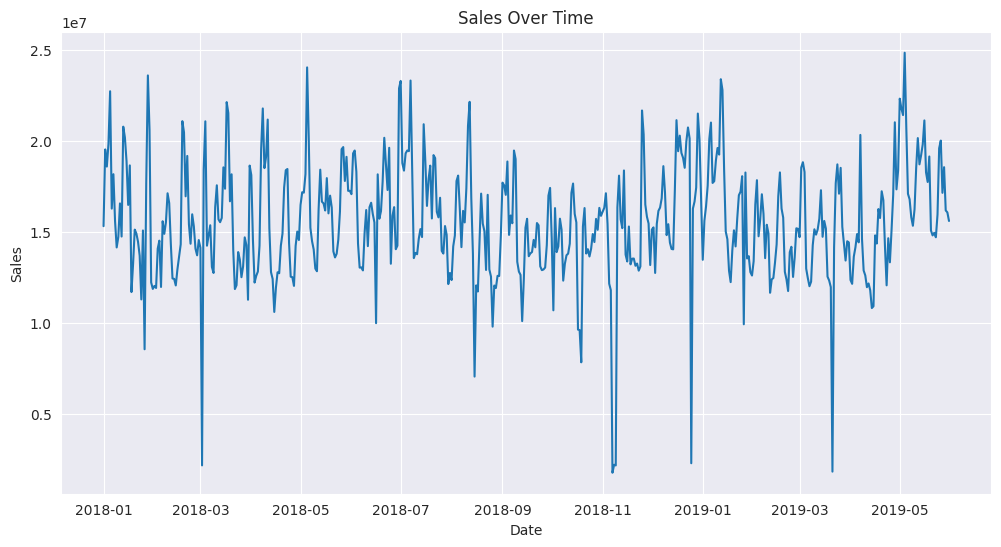

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Sales'])
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

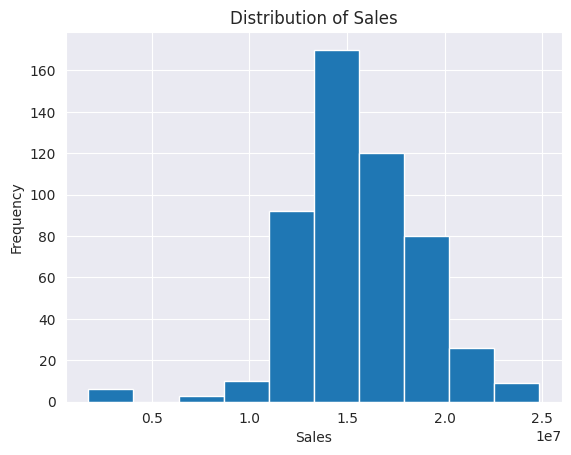

In [ ]:
plt.hist(data['Sales'])
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

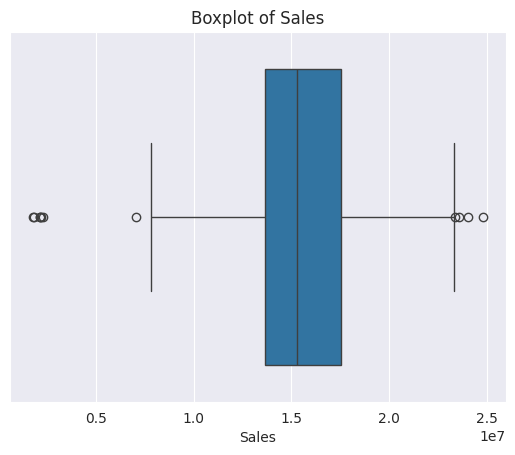

In [ ]:
sns.boxplot(x=data['Sales'])
plt.title('Boxplot of Sales')
plt.show()

In [ ]:
data.describe()

Holiday    Discount         Sales
count  516.000000  516.000000  5.160000e+02
mean     0.131783    0.011628  1.555606e+07
std      0.338583    0.107308  3.187167e+06
min      0.000000    0.000000  1.762138e+06
25%      0.000000    0.000000  1.365264e+07
50%      0.000000    0.000000  1.530204e+07
75%      0.000000    0.000000  1.753742e+07
max      1.000000    1.000000  2.483606e+07

In [ ]:
data.index = pd.to_datetime(data.index)

In [ ]:
ts_train = data.loc[:"2019-03-31"]
ts_val = data.loc["2019-04-01":]
ts_train.shape, ts_val.shape

((455, 3), (61, 3))

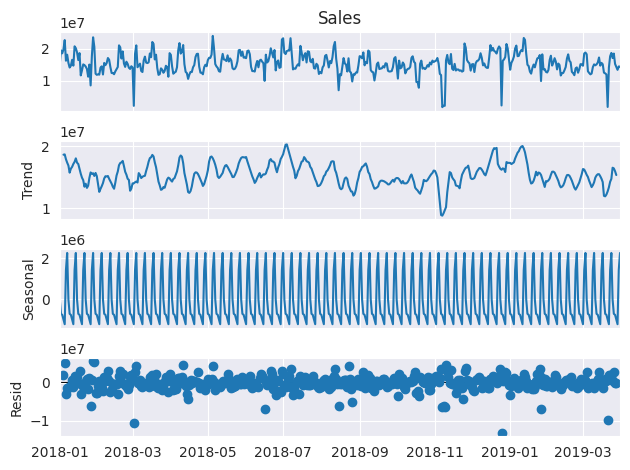

In [ ]:
# Decompose the time series
decomposition = seasonal_decompose(ts_train['Sales'], model='additive')

# Plot the decomposed components
decomposition.plot()
plt.show()

#### **Stationarity test and decomposition**

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Creating a function to test the stationarity
def adf_test(dataset):
   pvalue = adfuller(dataset)[1]
   if pvalue < 0.05:
      print('Sequence is stationary')
   else:
      print('Sequence is not stationary')

adf_test(ts_train['Sales'])

Sequence is stationary


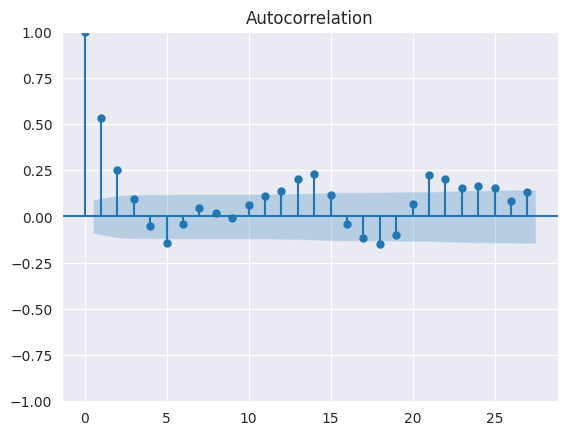

In [ ]:
plot_acf(ts_train['Sales'])
plt.show()

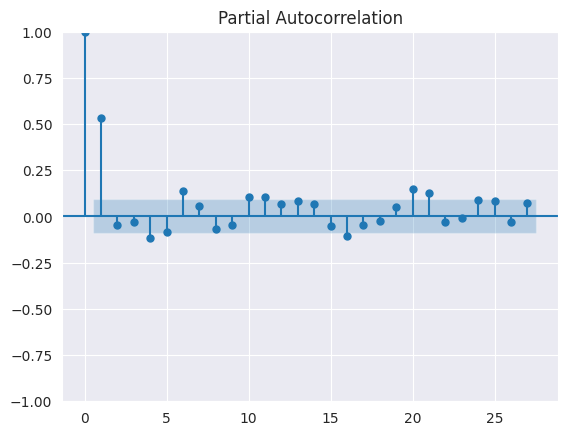

In [ ]:
plot_pacf(ts_train['Sales'])
plt.show()

#### **ARIMA Model**

In [ ]:
# Fit ARIMA model
model = ARIMA(ts_train['Sales'], order=(1, 0, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  455
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7380.587
Date:                Sun, 04 Aug 2024   AIC                          14769.175
Time:                        11:13:48   BIC                          14785.656
Sample:                    01-01-2018   HQIC                         14775.667
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+07   2.67e+05     57.855      0.000    1.49e+07     1.6e+07
ar.L1          0.4749      0.062      7.717      0.000       0.354       0.596
ma.L1          0.0828      0.071      1.173      0.2

In [ ]:
# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mean_absolute_error(actual, predicted), 3))
    print('RMSE :', round(mean_squared_error(actual, predicted)**0.5, 3))
    print('MAPE:', round(mean_absolute_percentage_error(actual, predicted), 3))

In [ ]:
model = ARIMA(ts_train['Sales'], order=(1,0,0)).fit()
pred_arima = model.forecast(steps= len(ts_val))
performance(ts_val['Sales'].values, pred_arima)

MAE : 2555990.575
RMSE : 3241308.388
MAPE: 0.152


In [ ]:
model = ARIMA(ts_train['Sales'], order=(1,0,1)).fit()
pred_arima = model.forecast(steps= len(ts_val))
performance(ts_val['Sales'].values, pred_arima)

MAE : 2558335.411
RMSE : 3242549.698
MAPE: 0.152


In [ ]:
for i in range(10):
  p = np.random.randint(0,10)
  q = np.random.randint(0,10)
  print(p,q)

  model = ARIMA(ts_train['Sales'], order=(p,0,q)).fit()
  pred_arima = model.forecast(steps= len(ts_val))
  performance(ts_val['Sales'].values, pred_arima)

1 4
MAE : 2562779.041
RMSE : 3245110.543
MAPE: 0.153
1 1
MAE : 2558335.411
RMSE : 3242549.698
MAPE: 0.152
6 8
MAE : 2322189.493
RMSE : 2852691.355
MAPE: 0.138
0 4
MAE : 2560653.776
RMSE : 3243637.681
MAPE: 0.153
5 1
MAE : 2579989.907
RMSE : 3252778.579
MAPE: 0.154
3 5
MAE : 2559440.609
RMSE : 3240567.488
MAPE: 0.152
7 3
MAE : 2549496.569
RMSE : 3222142.386
MAPE: 0.152
5 0
MAE : 2576306.292
RMSE : 3248576.111
MAPE: 0.154
4 5
MAE : 2587479.133
RMSE : 3269340.475
MAPE: 0.155
4 2
MAE : 2558472.829
RMSE : 3240199.768
MAPE: 0.152


In [ ]:
model = ARIMA(ts_train['Sales'], order=(1,0,0)).fit()
pred_arima = model.forecast(steps= len(ts_val))

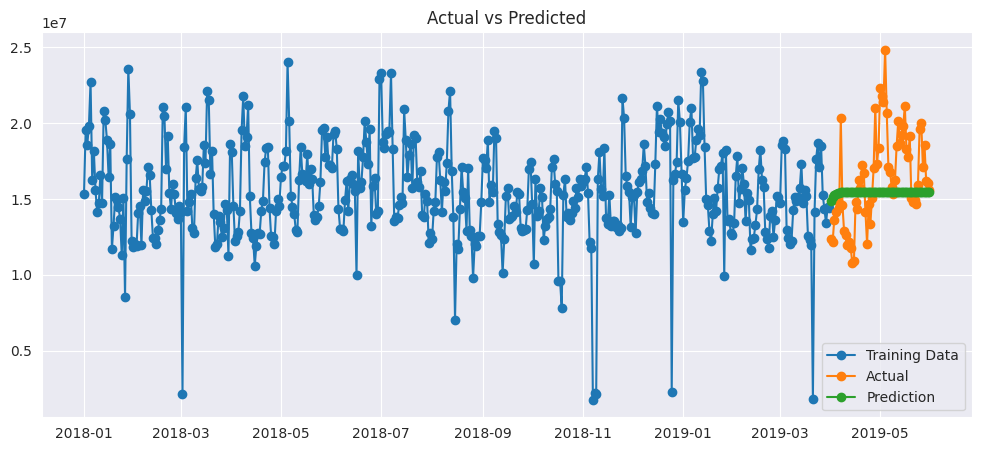

In [ ]:
plt.figure(figsize= (12,5));
plt.plot(ts_train['Sales'], '-o', label='Training Data');
plt.title("Actual vs Predicted");
plt.plot(ts_val['Sales'], '-o', label='Actual');
plt.plot(pred_arima, '-o', label='Prediction');
plt.legend();
plt.show()

#### **Sarimax Model**

In [ ]:
data.head()

Holiday  Discount       Sales
Date                                     
2018-01-01        1         1  15307504.2
2018-01-02        0         1  19523661.0
2018-01-03        0         1  18581103.0
2018-01-04        0         0  19831773.0
2018-01-05        0         0  22719033.0

In [ ]:
train_sm = data.loc[:"2019-03-31"]
test_sm = data.loc["2019-04-01":]
train_sm.shape, test_sm.shape

((455, 3), (61, 3))

In [ ]:
m2 = SARIMAX(train_sm['Sales'], exog=train_sm[['Holiday', 'Discount']], order=(1,0,0), seasonal_order=(1,1,1,12),
                            enforce_stationarity=False, enforce_invertibility=False).fit()

pred_sarimax = m2.forecast(steps=len(test_sm), exog=test_sm[["Holiday", "Discount"]])
performance(test_sm['Sales'], pred_sarimax)

MAE : 2734109.327
RMSE : 3499041.152
MAPE: 0.158


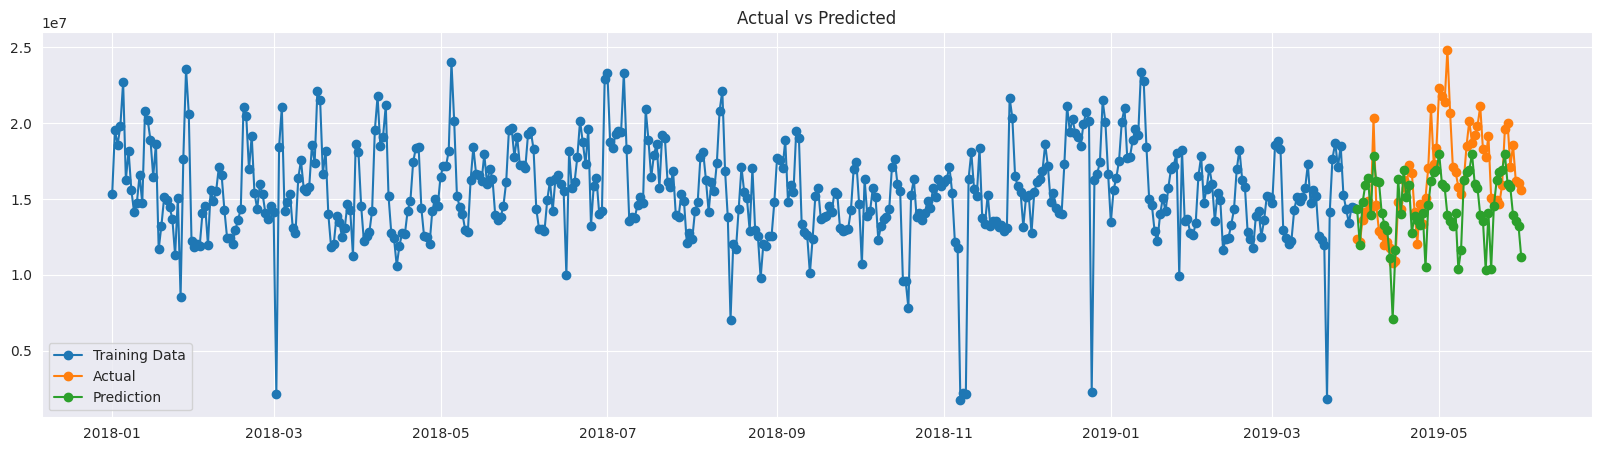

In [ ]:
plt.figure(figsize=(20, 5))

# Convert the index to DatetimeIndex if it's not already
plt.plot(pd.to_datetime(train_sm['Sales'].index), train_sm['Sales'].values, '-o', label='Training Data')
plt.title("Actual vs Predicted")

# Convert the index to DatetimeIndex if it's not already
plt.plot(pd.to_datetime(test_sm['Sales'].index), test_sm['Sales'].values, '-o', label='Actual')

# If pred_sarimax is a Pandas Series with a DatetimeIndex:
plt.plot(pred_sarimax.index.to_pydatetime(), pred_sarimax.values, '-o', label='Prediction')
# If pred_sarimax is a NumPy array, you might need to generate date values for the x-axis
# For example:
# plt.plot(pd.date_range(start=test_sm.index.min(), periods=len(pred_sarimax), freq='D'), pred_sarimax, '-o', label='Prediction')

plt.legend()
plt.show()

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

exog = train_sm[['Holiday', 'Discount']]
y = train_sm['Sales']

# Define the objective function
def objective(params):
    order = (params['p'], params['d'], params['q'])
    seasonal_order = (params['P'], params['D'], params['Q'], params['S'])

    # Fit the model
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order, exog=exog)
    model_fit = model.fit(disp=False)

    # Predict and calculate the error
    y_pred = model_fit.predict(start=0, end=len(y)-1, exog=exog)
    mse = mean_squared_error(y, y_pred)

    return {'loss': mse, 'status': STATUS_OK}

# Define the search space
space = {
    'p': hp.choice('p', range(0, 5)),
    'd': hp.choice('d', range(0, 2)),
    'q': hp.choice('q', range(0, 5)),
    'P': hp.choice('P', range(0, 3)),
    'D': hp.choice('D', range(0, 2)),
    'Q': hp.choice('Q', range(0, 3)),
    'S': hp.choice('S', [12]),
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print(best)

100%|██████████| 50/50 [07:24<00:00,  8.90s/trial, best loss: 7063194867251.634]
{'D': 0, 'P': 2, 'Q': 0, 'S': 0, 'd': 1, 'p': 4, 'q': 4}


```
{'D': 0, 'P': 2, 'Q': 0, 'S': 0, 'd': 1, 'p': 4, 'q': 4}
```

In [ ]:
model_1 = SARIMAX(y,
                order=(4, 1, 4),
                seasonal_order=(0, 0, 0, 0),
                exog=exog)

model_fit1 = model_1.fit(disp=False)
print(model_fit1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  455
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -7331.615
Date:                Sun, 04 Aug 2024   AIC                          14685.230
Time:                        11:52:41   BIC                          14730.530
Sample:                    01-01-2018   HQIC                         14703.078
                         - 03-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday    -2.074e+06    1.5e-08  -1.38e+14      0.000   -2.07e+06   -2.07e+06
Discount   -2.951e+06   2.19e-09  -1.35e+15      0.000   -2.95e+06   -2.95e+06
ar.L1         -0.8523      0.042    -20.211      0.0

In [ ]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the model with the optimized parameters
model_2 = SARIMAX(y,
                order=(4, 1, 4),
                seasonal_order=(2, 0, 0, 12),
                exog=exog)

model_fit2 = model_2.fit(disp=False)
print(model_fit2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                  455
Model:             SARIMAX(4, 1, 4)x(2, 0, [], 12)   Log Likelihood               -7328.478
Date:                             Sun, 04 Aug 2024   AIC                          14682.956
Time:                                     11:55:54   BIC                          14736.491
Sample:                                 01-01-2018   HQIC                         14704.048
                                      - 03-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Holiday    -2.074e+06   1.48e-08   -1.4e+14      0.000   -2.07e+06   -2.07e+06
Discount   -2.951e+06   2.0

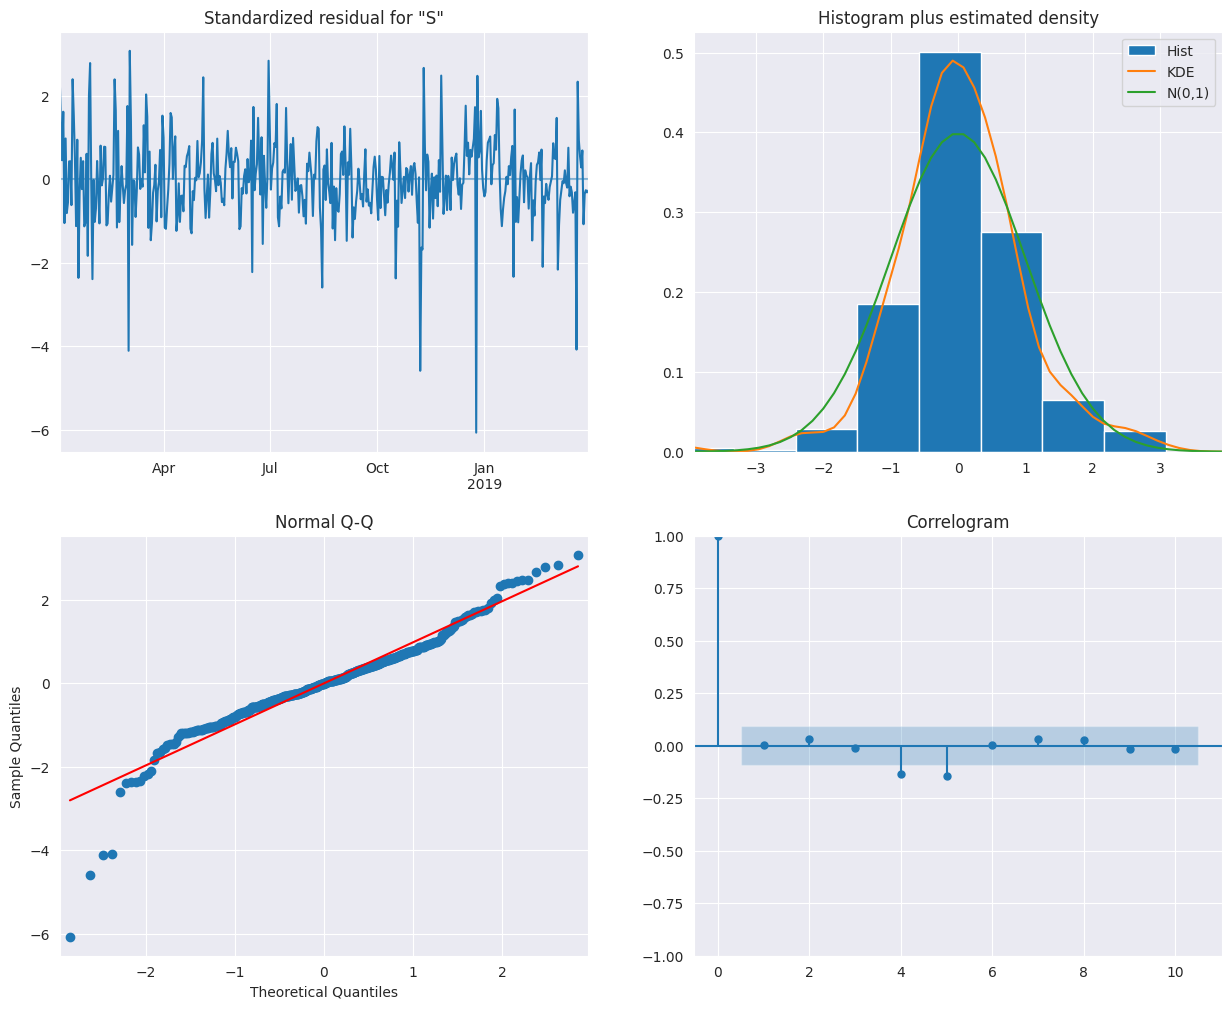

In [ ]:
model_fit1.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX # Already imported in a previous cell

# Fit the model with the optimized parameters
model_2 = SARIMAX(y,
                order=(4, 1, 4),
                seasonal_order=(2, 0, 0, 12),
                exog=exog)

# Fit the model, store the results, and then forecast
results_model2 = model_2.fit(disp=False)
pred_sarimax = results_model2.forecast(steps=len(test_sm), exog=test_sm[["Holiday", "Discount"]])

performance(test_sm['Sales'], pred_sarimax)

MAE : 2459959.693
RMSE : 3047867.18
MAPE: 0.145


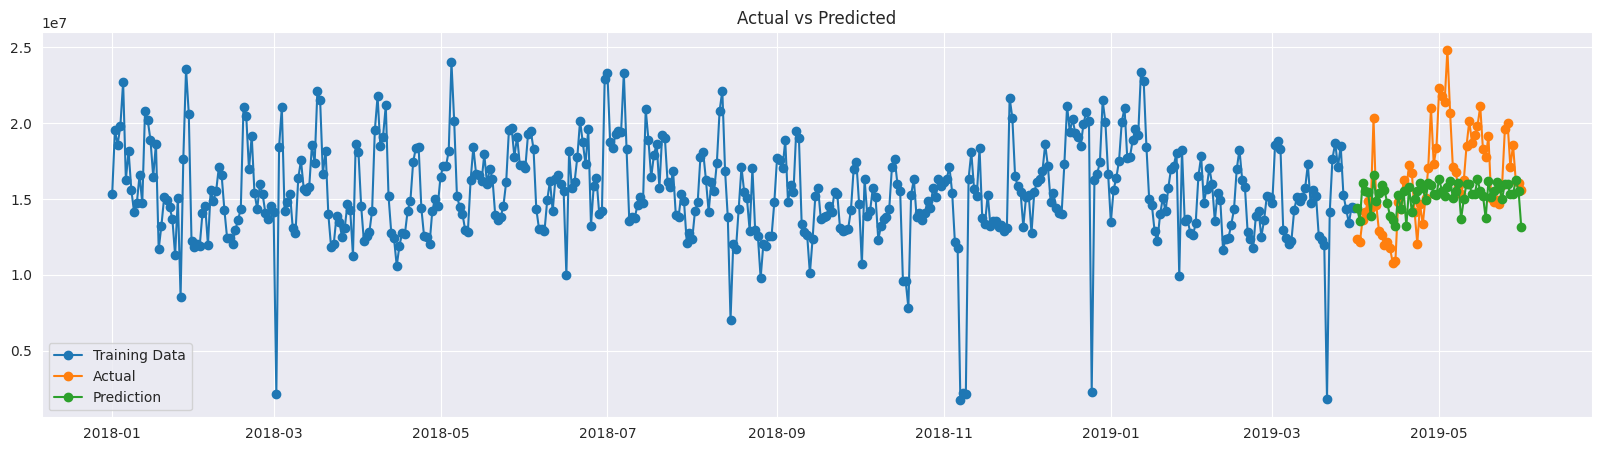

In [ ]:
plt.figure(figsize=(20, 5))

# Convert the index to DatetimeIndex if it's not already
plt.plot(pd.to_datetime(train_sm['Sales'].index), train_sm['Sales'].values, '-o', label='Training Data')
plt.title("Actual vs Predicted")

# Convert the index to DatetimeIndex if it's not already
plt.plot(pd.to_datetime(test_sm['Sales'].index), test_sm['Sales'].values, '-o', label='Actual')

# If pred_sarimax is a Pandas Series with a DatetimeIndex:
plt.plot(pred_sarimax.index.to_pydatetime(), pred_sarimax.values, '-o', label='Prediction')
# If pred_sarimax is a NumPy array, you might need to generate date values for the x-axis
# For example:
# plt.plot(pd.date_range(start=test_sm.index.min(), periods=len(pred_sarimax), freq='D'), pred_sarimax, '-o', label='Prediction')

plt.legend()
plt.show()

### **Ensemble: Stacking**

In [ ]:
# Define the base models
estimators = [
    ('LinearRegression', lr),
    ('DecisionTree', dt),
    ('RandomForest', rf),
    ('LightGBM', lgbm),
]

# Defining the meta-learner (Another Linear Regression)
final_estimator = LinearRegression()

# Create the stacking regressor
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5  # Number of cross-validation folds
)

In [ ]:
# Fit the stacking regressor on the training data
stacking_regressor.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 150672, number of used features: 114
[LightGBM] [Info] Start training from score 42607.305760
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 120537, number of used features: 114
[LightGBM] [Info] Start training from score 42614.354145
[LightGBM] [Warnin

StackingRegressor(cv=5,
                  estimators=[('LinearRegression', LinearRegression()),
                              ('DecisionTree',
                               DecisionTreeRegressor(min_samples_leaf=5,
                                                     min_samples_split=20)),
                              ('RandomForest',
                               RandomForestRegressor(max_depth=20,
                                                     min_samples_leaf=5,
                                                     min_samples_split=10)),
                              ('LightGBM',
                               LGBMRegressor(max_depth=10, n_estimators=200,
                                             num_leaves=50))],
                  final_estimator=LinearRegression())

In [ ]:
# Evaluate the stacking regressor
res = model_evaluation(stacking_regressor, X_train, y_train, X_val, y_val)
res['model_performance_matrices']

{'Train_R2': 0.7704449362194231,
 'Test_R2': 0.7575458620778306,
 'Train_Adjested_R2': 0.7702711198092198,
 'Test_Adjusted_R2': 0.7568098417406237,
 'MAE': 6220.659109732924,
 'MSE': 76205101.60072693,
 'RMSE': 8729.553344858312,
 'MAPE': 7644344840122485.0}

**Insights**

___

**Interpretation of Stacking Regressor Results:**

   - <font color=blue size =4> The Stacking Regressor achieved a Test R² of 0.7575, the highest among all models evaluated. This indicates that the stacked model explains approximately 75.8% of the variance in the validation data, reflecting improved performance compared to individual models like LightGBM, Random Forest, and Decision Tree.

   - <font color=blue size =4> The MAE and RMSE values are the lowest among the tested models, suggesting that the Stacking Regressor provides the most accurate predictions overall.

   - <font color=blue size =4> The Train R² and Test R² values are closely aligned, indicating that the model generalizes well and is not overfitting.

   - <font color=blue size =4> In summary, the Stacking Regressor, with its Linear Regression meta-learner, has demonstrated superior predictive accuracy and robustness. Its ability to leverage the strengths of multiple base models and provide improved performance makes it the best choice for the final model in this sales prediction task.


---

### **Saving Results**

In [ ]:
# with open('productSales_stacking_regressor.pkl', 'wb') as f:
#   pickle.dump(stacking_regressor, f)

# files.download('productSales_stacking_regressor.pkl')